# Исследование рынка видеоигр

Интернет-магазин "Стримчик" продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation).\
**Задача:** выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.\
В нашем распоряжении находятcя данные до 2016 года, на основе которых необходимо запланировать кампанию на 2017 год.

**Описание данных:**
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.\
Данные за 2016 год могут быть неполными.

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import datetime

import seaborn as sns

import re

from scipy import stats as st
from scipy.stats import binom
from scipy.stats import binomtest

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

from math import factorial
from math import sqrt

from IPython.display import display_html

# настроим среду
sns.set(rc={'figure.figsize':(15,5)})
pd.set_option('display.max_columns', None)
pd.set_option("display.float_format", "{:.2f}".format)

Обновлю matplotlib, чтобы добавлять подписи значений на графиках

In [2]:
!pip install matplotlib --upgrade

## Изучение данных

Загрузим данные в датафрейм df

In [3]:
df = pd.read_csv('C:/Users/drweb/datasets/games.csv')

Выведем основную информацию о дф и 10 первых строк

In [4]:
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.00,Sports,41.36,28.96,3.77,8.45,76.00,8,E
1,Super Mario Bros.,NES,1985.00,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.00,Racing,15.68,12.76,3.79,3.29,82.00,8.3,E
3,Wii Sports Resort,Wii,2009.00,Sports,15.61,10.93,3.28,2.95,80.00,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.00,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.00,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.00,Platform,11.28,9.14,6.50,2.88,89.00,8.5,E
7,Wii Play,Wii,2006.00,Misc,13.96,9.18,2.93,2.84,58.00,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.00,Platform,14.44,6.94,4.70,2.24,87.00,8.4,E
9,Duck Hunt,NES,1984.00,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


В таблице представлено 16715 строк и 11 столбцов:
- name, platform, genre, user_score, rating с типом данных object;
- year_of_release, NA_sales, EU_sales, JP_sales, other_sales, critic_score с типом данных float.\
1) Необходимо привести названия столбцов к единому стилю.\
2) Обработать пропуски в данных, а также объяснить, чем их возможно заменить.\
3) Преобразовать столбцы в необходимые типы данных.\
4) Добавить столбец с суммарными продажами по всем регионам.

Отобразим описательную статистику

In [5]:
df.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.00,16715.00,16715.00,16715.00,16715.00,8137.00
mean,2006.48,0.26,0.15,0.08,0.05,68.97
std,5.88,0.81,0.50,0.31,0.19,13.94
min,1980.00,0.00,0.00,0.00,0.00,13.00
25%,2003.00,0.00,0.00,0.00,0.00,60.00
50%,2007.00,0.08,0.02,0.00,0.01,71.00
75%,2010.00,0.24,0.11,0.04,0.03,79.00
max,2016.00,41.36,28.96,10.22,10.57,98.00


На первый взгляд, данные в порядке, каких-либо необъяснимых значений по данной описательной статистике нет

## Предобработка данных

### Приведение столбцов к единому стилю

In [6]:
df.columns = map(str.lower, df.columns)

In [7]:
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [8]:
df.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.00,Sports,41.36,28.96,3.77,8.45,76.00,8,E
1,Super Mario Bros.,NES,1985.00,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.00,Racing,15.68,12.76,3.79,3.29,82.00,8.3,E
3,Wii Sports Resort,Wii,2009.00,Sports,15.61,10.93,3.28,2.95,80.00,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.00,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.00,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.00,Platform,11.28,9.14,6.50,2.88,89.00,8.5,E
7,Wii Play,Wii,2006.00,Misc,13.96,9.18,2.93,2.84,58.00,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.00,Platform,14.44,6.94,4.70,2.24,87.00,8.4,E
9,Duck Hunt,NES,1984.00,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


### Обработка пропусков

In [9]:
df.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Построим график пропущенных значений

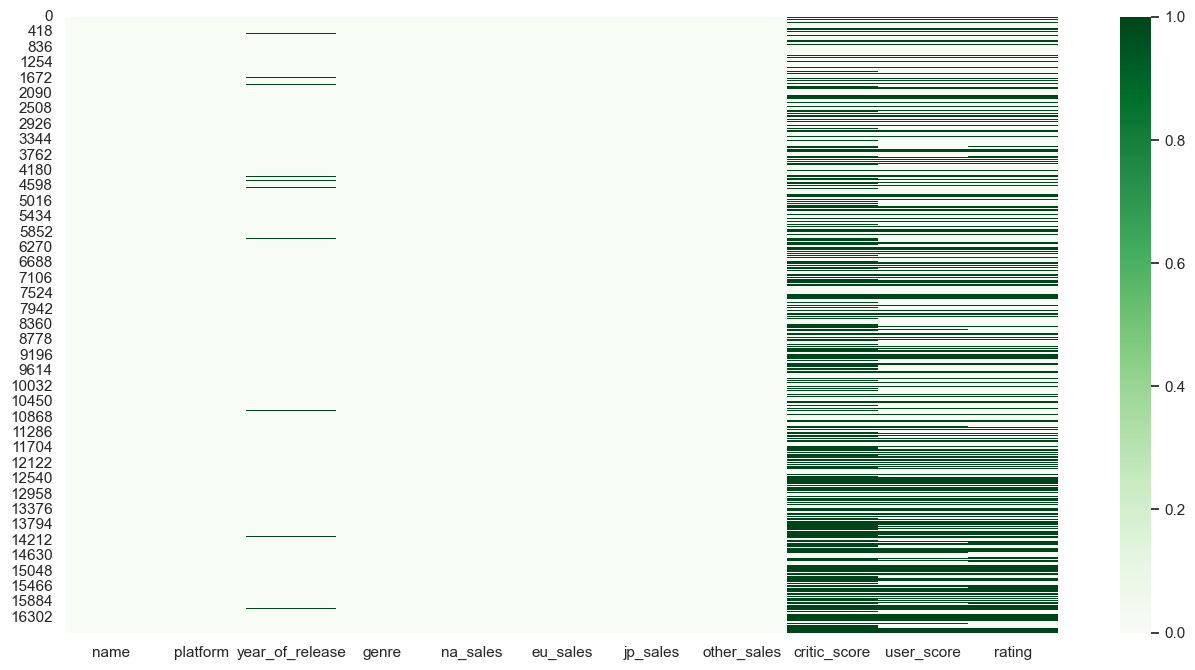

In [10]:
plt.figure(figsize=(16,8))
sns.heatmap(df.isna(),cmap = 'Greens')
plt.show()

Посчитаем долю пропущенных значений

In [11]:
df.isnull().mean() * 100

name               0.01
platform           0.00
year_of_release    1.61
genre              0.01
na_sales           0.00
eu_sales           0.00
jp_sales           0.00
other_sales        0.00
critic_score      51.32
user_score        40.09
rating            40.48
dtype: float64

В столбцах critic_score, user_score, rating пропущено свыше 40% значений

Выведем пропущенные значения в столбце name

In [12]:
df[df['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.00,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.00,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Поскольку нет никакой информации, которая могла бы подсказать, чем можно заполнить эти данные, удалим их

In [13]:
df = df.dropna(subset=['name']).reset_index(drop=True)
# благодаря этому шагу также удалятся пропуски из столбца genre

In [14]:
df['name'].isna().sum()

0

Посмотрим на пропуски в столбце year of release

In [15]:
df[df['year_of_release'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.00,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.00,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.00,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16371,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.00,tbd,E10+
16403,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.00,6.5,T
16446,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.00,6.7,M
16456,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Отобразим строки, где в названии игры может быть указана дата выхода игры

In [16]:
df[(df['name'].str.contains(r'19') == True)|(df['name'].str.contains(r'20') == True) & (df['year_of_release'].isna())]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.00,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.00,6.4,E
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
1649,NASCAR Thunder 2003,PS2,NaN,Racing,0.60,0.46,0.00,0.16,84.00,8.7,E
2061,1942,NES,1985.00,Shooter,0.65,0.14,0.21,0.00,NaN,NaN,NaN
2491,MLB SlugFest 20-03,PS2,NaN,Sports,0.41,0.32,0.00,0.11,77.00,8.2,E
2571,PES 2009: Pro Evolution Soccer,PSP,NaN,Sports,0.04,0.33,0.26,0.17,NaN,NaN,NaN
3485,Madden NFL 2002,XB,NaN,Sports,0.53,0.02,0.00,0.03,90.00,8.1,E
3686,Gekikuukan Pro Yakyuu: At the End of the Centu...,PS2,2000.00,Sports,0.00,0.00,0.54,0.00,NaN,NaN,NaN
4774,NFL GameDay 2003,PS2,NaN,Sports,0.20,0.15,0.00,0.05,60.00,tbd,E


Некоторые названия игр содержат год выпуска, однако название игры может быть обманчиво, поскольку, к примеру, Battlefield 1942 уж точно не вышел в 1942 году, название в этом случае описывает год происходящих в игре событий, к тому же выход одной игры на разные платформы может растянуться на несколько лет, поэтому просто удалим пропуски, поскольку их немного (около 1.6%), чтобы они не мешали анализу

Удалим пропуски в столбце year of release

In [17]:
df.dropna(subset=['year_of_release'], inplace=True)

Посмотрим на пропуски в столбце critic score

In [18]:
df.query('critic_score.isna()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985.00,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996.00,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.00,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984.00,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005.00,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16708,Samurai Warriors: Sanada Maru,PS3,2016.00,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16709,LMA Manager 2007,X360,2006.00,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16710,Haitaka no Psychedelica,PSV,2016.00,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,Spirits & Spells,GBA,2003.00,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Посмотрим на пропуски в столбце user score

In [19]:
df.query('user_score.isna()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985.00,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996.00,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.00,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984.00,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005.00,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16708,Samurai Warriors: Sanada Maru,PS3,2016.00,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16709,LMA Manager 2007,X360,2006.00,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16710,Haitaka no Psychedelica,PSV,2016.00,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,Spirits & Spells,GBA,2003.00,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Посмотрим на пропуски в столбце rating

In [20]:
df.query('rating.isna()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985.00,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996.00,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.00,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984.00,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005.00,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16708,Samurai Warriors: Sanada Maru,PS3,2016.00,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16709,LMA Manager 2007,X360,2006.00,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16710,Haitaka no Psychedelica,PSV,2016.00,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,Spirits & Spells,GBA,2003.00,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Заменим пропуски в столбце rating

Можем заменить пропуски в столбце на NOT DEFINED(ND) - не определено

In [21]:
df['rating'] = df['rating'].fillna('ND')

Непонятно, чем стоит заполнить пропуски в столбцах user_score и critic_score. Возможно, единственным способом заполнения в данном случае является заполнение вручную, что очень долго по времени.\
Причиной возникновения такого количества пропусков может быть ошибка при выгрузке данных, человеческий фактор, либо же неизвестность многих игр, в результате чего им не выставлялись оценки.\
Исходя из вышесказанного, оставим эти столбцы как есть.

In [22]:
df.isnull().mean() * 100

name               0.00
platform           0.00
year_of_release    0.00
genre              0.00
na_sales           0.00
eu_sales           0.00
jp_sales           0.00
other_sales        0.00
critic_score      51.45
user_score        40.17
rating             0.00
dtype: float64

### Обработка дубликатов

In [23]:
df.duplicated().sum()

0

Посмотрим как выглядят данные в столбце platform и genre, там могут быть неявные дубликаты

In [24]:
df['platform'].value_counts()

platform
PS2     2127
DS      2121
PS3     1306
Wii     1286
X360    1232
PSP     1193
PS      1190
PC       957
GBA      811
XB       803
GC       542
3DS      512
PSV      429
PS4      392
N64      316
XOne     247
SNES     239
SAT      173
WiiU     147
2600     116
NES       98
GB        97
DC        52
GEN       27
NG        12
SCD        6
WS         6
3DO        3
TG16       2
GG         1
PCFX       1
Name: count, dtype: int64

In [25]:
df['genre'].value_counts()

genre
Action          3307
Sports          2306
Misc            1721
Role-Playing    1481
Shooter         1296
Adventure       1293
Racing          1226
Platform         878
Simulation       857
Fighting         837
Strategy         673
Puzzle           569
Name: count, dtype: int64

Проверим неявные дубликаты по столбцам name, platform, year 0f release

In [26]:
df[df.duplicated(subset=['name', 'platform', 'year_of_release'])]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
16228,Madden NFL 13,PS3,2012.00,Sports,0.00,0.01,0.00,0.00,83.00,5.5,E


In [27]:
df = df.drop_duplicates(subset=['name', 'platform', 'year_of_release']).reset_index(drop=True)

In [28]:
df[df.duplicated(subset=['name', 'platform', 'year_of_release'])]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


**Дубликатов в датафрейме нет**

### Изменение типов данных

Первым делом разберемся со значениями "tbd" в столбце user score. Данная аббревиатура означат "to be defined" или рейтинг не определён. Никакой ценности значения, обозначенные таким образом, не представляют, и, наоборот, даже мешают, к примеру, привести тип данных в столбце на необходимый.\
Поэтому заменим значения tbd на пропуски (nan).

In [29]:
df['user_score'].value_counts()

user_score
tbd    2376
7.8     322
8       285
8.2     276
8.3     252
       ... 
1.1       2
1.9       2
9.6       2
0         1
9.7       1
Name: count, Length: 96, dtype: int64

In [30]:
df['user_score'] = df['user_score'].replace('tbd', np.nan)

Отобразим распределение игр по рейтингам

In [31]:
df['rating'].value_counts()

rating
ND      6676
E       3920
T       2905
M       1536
E10+    1393
EC         8
K-A        3
AO         1
RP         1
Name: count, dtype: int64

Заменим устаревший К-А на E

In [32]:
df['rating'] = df['rating'].replace('K-A', 'E')

Заменим типы данных в столбцах

In [33]:
df['year_of_release'] = df['year_of_release'].astype('int')

df['user_score'] = df['user_score'].astype('float')

Проверим, что получилось

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16443 entries, 0 to 16442
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  int32  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     7982 non-null   float64
 9   user_score       7462 non-null   float64
 10  rating           16443 non-null  object 
dtypes: float64(6), int32(1), object(4)
memory usage: 1.3+ MB


In [35]:
df.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.00,8.00,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,ND
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.00,8.30,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.00,8.00,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,ND
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,ND
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.00,8.50,E
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.00,6.60,E
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.00,8.40,E
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,ND


### Добавление столбца

Добавим столбец с совокупным объёмом продаж путём суммирования объёмов продаж в каждом из регионов

In [36]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

Посмотрим, корректно ли добавился столбец

In [37]:
df.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.00,8.00,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,ND,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.00,8.30,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.00,8.00,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,ND,31.38
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,ND,30.26
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.00,8.50,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.00,6.60,E,28.91
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.00,8.40,E,28.32
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,ND,28.31


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16443 entries, 0 to 16442
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  int32  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     7982 non-null   float64
 9   user_score       7462 non-null   float64
 10  rating           16443 non-null  object 
 11  total_sales      16443 non-null  float64
dtypes: float64(7), int32(1), object(4)
memory usage: 1.4+ MB


**Вывод:**  
1) Приведены к единому стилю названия столбцов.  
2) Обработаны и объяснены пропуски (в т.ч. ликвидировано значение "tbd" в столбце rating, мешавшее анализу.  
3) Проверено наличие дубликатов.  
4) Добавлен столбец total_sales с общим кол-вом проданных копий видеоигр.

## Исследовательский анализ данных

Посмотрим на описательную статистику

In [39]:
df.describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales
count,16443.00,16443.00,16443.00,16443.00,16443.00,7982.00,7462.00,16443.00
mean,2006.49,0.26,0.15,0.08,0.05,68.99,7.13,0.54
std,5.88,0.82,0.51,0.31,0.19,13.92,1.50,1.56
min,1980.00,0.00,0.00,0.00,0.00,13.00,0.00,0.00
1%,1987.00,0.00,0.00,0.00,0.00,31.81,2.36,0.01
5%,1996.00,0.00,0.00,0.00,0.00,43.00,4.10,0.02
25%,2003.00,0.00,0.00,0.00,0.00,60.00,6.40,0.06
50%,2007.00,0.08,0.02,0.00,0.01,71.00,7.50,0.17
75%,2010.00,0.24,0.11,0.04,0.03,79.00,8.20,0.47
95%,2015.00,1.06,0.63,0.36,0.20,89.00,8.90,2.04


Данные не кажутся аномальными. В глаза сразу бросается тот факт, что по-настоящему успешных, мировых игр - менее 1%, если судить по объёмам продаж.

**ОБЩИЙ ВЫВОД:**

- названия столбцов приведены к нижнему регистру;
- данные преобразованы в необходимые типы;
- объяснены и ликвидированы пропуски там, где возможно;
- добавлен столбец с суммарными продажами по всем регионам.

### Cколько игр выпускалось в разные годы. Важны ли данные за все периоды?

Cоздадим датафрейм с кол-вом релизов игр по годам

In [40]:
games_by_year = df.groupby('year_of_release')['name'].count().reset_index()
games_by_year

,year_of_release,name
0,1980,9
1,1981,46
2,1982,36
3,1983,17
4,1984,14
5,1985,14
6,1986,21
7,1987,16
8,1988,15
9,1989,17


Построим график кол-ва релизов игр по годам

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


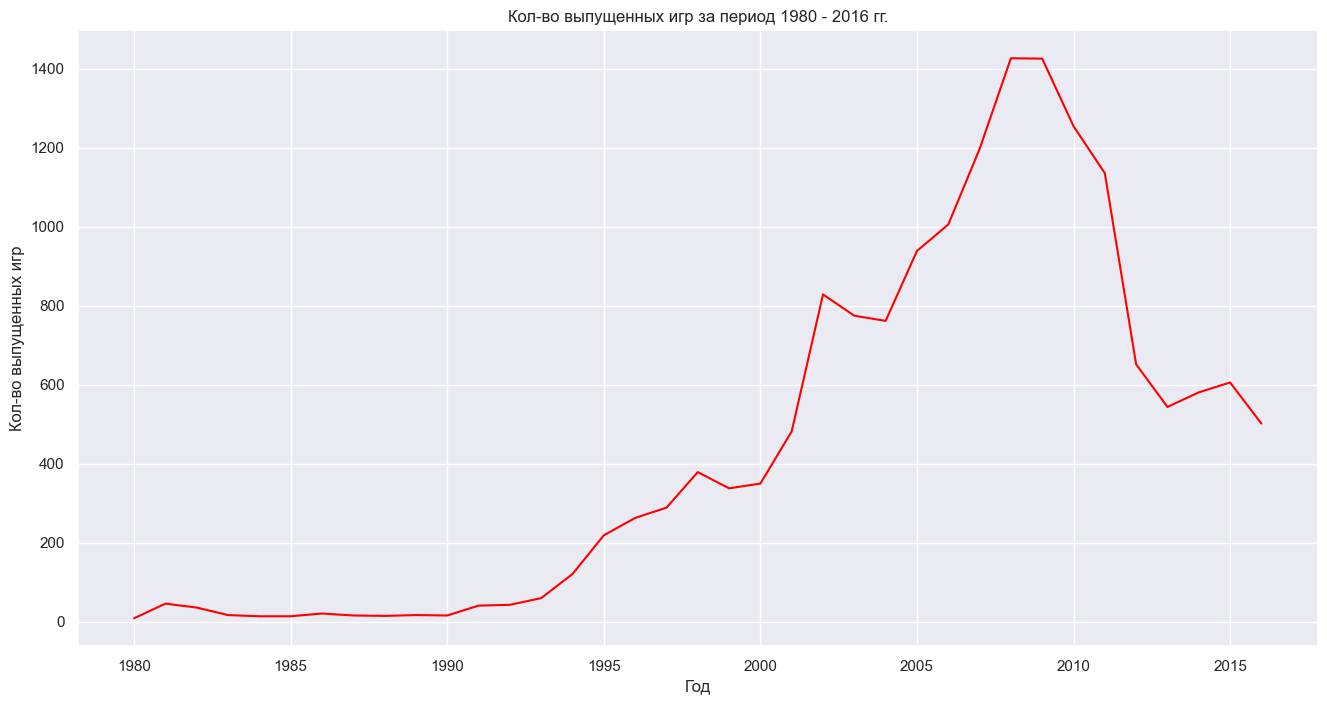

In [41]:
plt.figure(figsize=(16,8))
sns.lineplot(data=games_by_year, x='year_of_release', y='name', color='red')
plt.title('Кол-во выпущенных игр за период 1980 - 2016 гг.')
plt.xlabel('Год')
plt.ylabel('Кол-во выпущенных игр')
plt.show()

Первые игры появились в 1980-х годах. Поначалу их выпускалось немного (не больше 100), однако по мере развития технологий, появления всевозможных девайсов и гаджетов росло и кол-во выпускаемых видеоигр. Заметный рост начался, начиная с начала 1990-х годов. Пик индустрии приходится на 2008-2009 гг., в которых выпущено более 1400 видеоигр. Сразу после 2008-2009 гг. начался резкий спад производства видеоигр, который длился примерно до 2013 г. Вероятно, это обуловлено мировым экономическим кризисом, произошедшем в 2008 году. На конец наблюдения, а именно 2016 год выпущено около 500 видеоигр, при этом данные за 2016 год не полные.

Судя по графику, нас интересует период с 1994 года, поскольку период становления игроиндустрии в исследовании будет неактуален.

### Как менялись продажи по платформам? Установить платформы с наибольшими суммарными продажами и построить распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

Создадим новый столбец с категориями платформ: Мобильная,ПК, Приставка.

In [42]:
df['platform'].value_counts()

platform
PS2     2127
DS      2121
PS3     1305
Wii     1286
X360    1232
PSP     1193
PS      1190
PC       957
GBA      811
XB       803
GC       542
3DS      512
PSV      429
PS4      392
N64      316
XOne     247
SNES     239
SAT      173
WiiU     147
2600     116
NES       98
GB        97
DC        52
GEN       27
NG        12
SCD        6
WS         6
3DO        3
TG16       2
GG         1
PCFX       1
Name: count, dtype: int64

In [43]:
# для этого создадим функцию категоризации платформ; по открытым источникам определим, какая куда попадёт
def platform_type(platform):
    mobile = ['GB', 'DS', 'GBA', '3DS', 'PSP', 'PSV', 'GG']
    console = ['Wii', 'NES', 'X360', 'PS3', 'PS2', 'SNES', 'PS4', 'N64', 'PS', 'XB', '2600', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'SAT', 'SCD', 'WS', 'NG', 'TG16','3DO', 'PCFX']
    if platform in mobile:
        platform_type = 'Мобильная'
    if platform in console:
        platform_type = 'Консоль' 
    if platform == 'PC':
        platform_type = 'ПК'
    return platform_type

df['platform_type'] = df['platform'].apply(platform_type)

Для начала посмотрим как менялось количество выпущенных видеоигр в зависимости от типа платформы. Построим график

Период до 1994 года нас не интересует, отсечём его

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


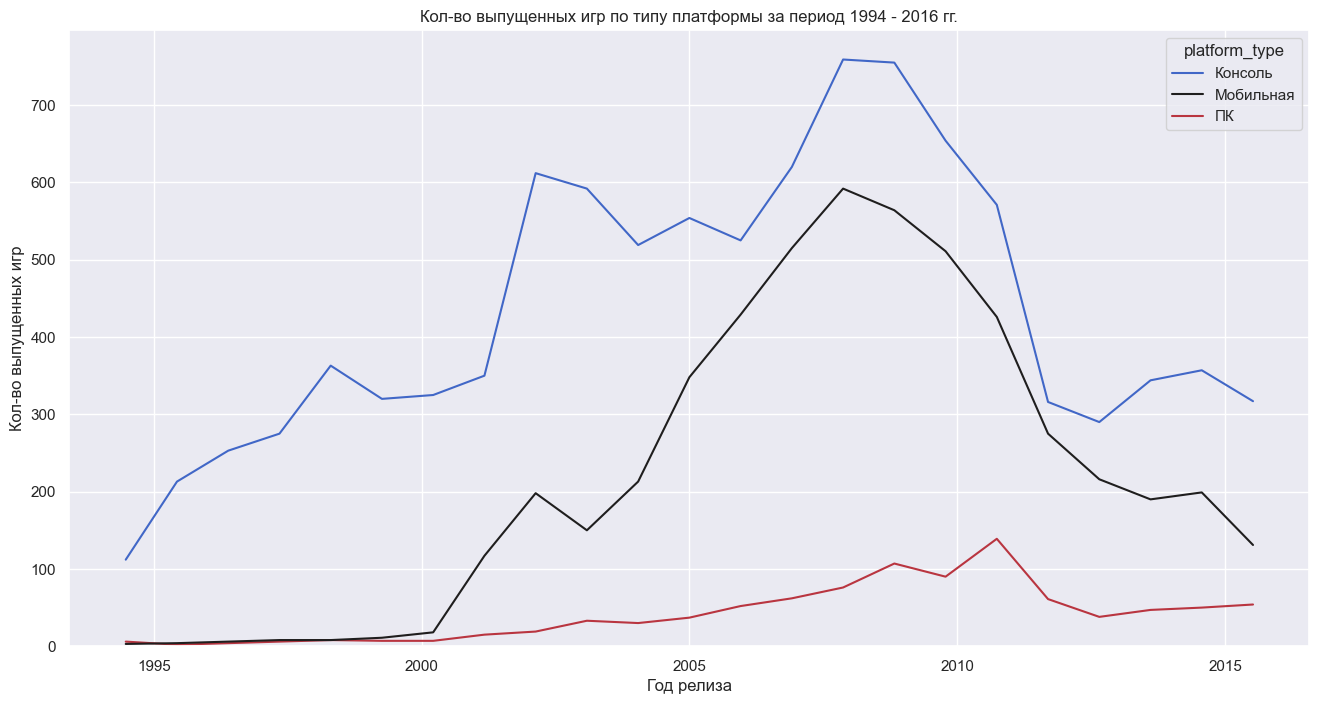

In [44]:
df_1994 = df.query('year_of_release > 1993')

plt.figure(figsize=(16,8))
sns.histplot(data=df_1994, hue='platform_type', x='year_of_release',\
             bins=23, palette='icefire', element='poly', fill=False)
plt.title('Кол-во выпущенных игр по типу платформы за период 1994 - 2016 гг.')
plt.xlabel('Год релиза')
plt.ylabel('Кол-во выпущенных игр')
plt.show()

Активный рост у всех типов начинается с 2000-х годов. Заметна общая тенденция к снижению кол-ва выпущенных игр после 2008 года, которая, однако, не коснулась ПК. Среди кол-ва релизов лидируют консоли, следом идут мобильные платформы. Меньше всего релизов у ПК.

Посмотрим как менялись продажи по платформам.

In [45]:
platforms_sum = df_1994.pivot_table(index='platform', values='total_sales', columns='year_of_release', aggfunc='sum')
platforms_count = df_1994.pivot_table(index='platform', values='total_sales', columns='year_of_release', aggfunc='count')

**Отобразим количество релизов игр по годам по типу платформ**

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


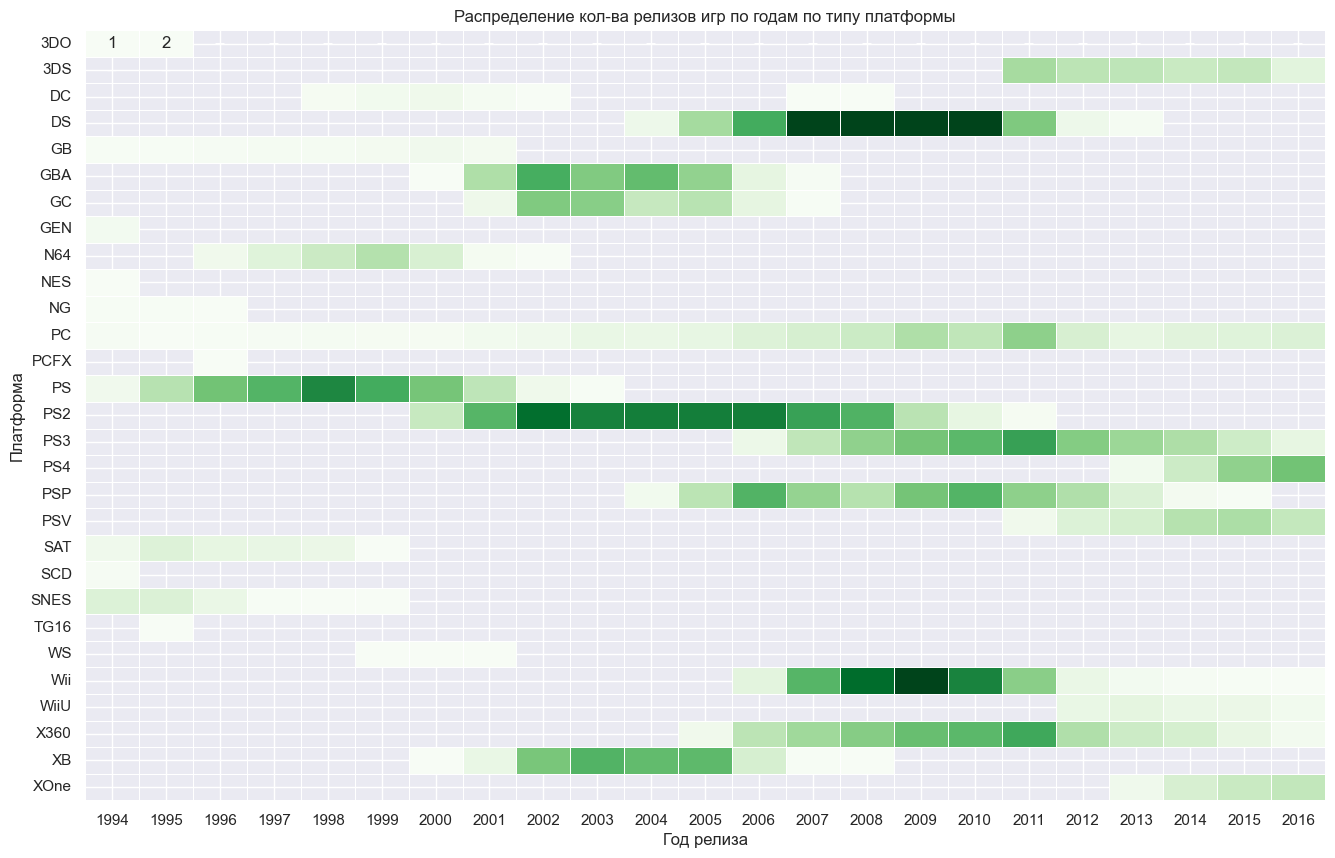

In [46]:
plt.figure(figsize=(16, 10))
sns.heatmap(data=platforms_count, annot=True, cbar=False, robust=True, linewidths=.5, fmt='.0f', cmap='Greens')
plt.title('Распределение кол-ва релизов игр по годам по типу платформы')
plt.xlabel('Год релиза')
plt.ylabel('Платформа')
plt.show()

**Отобразим распределение объёмов продаж игр по годам по типу платформ**

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


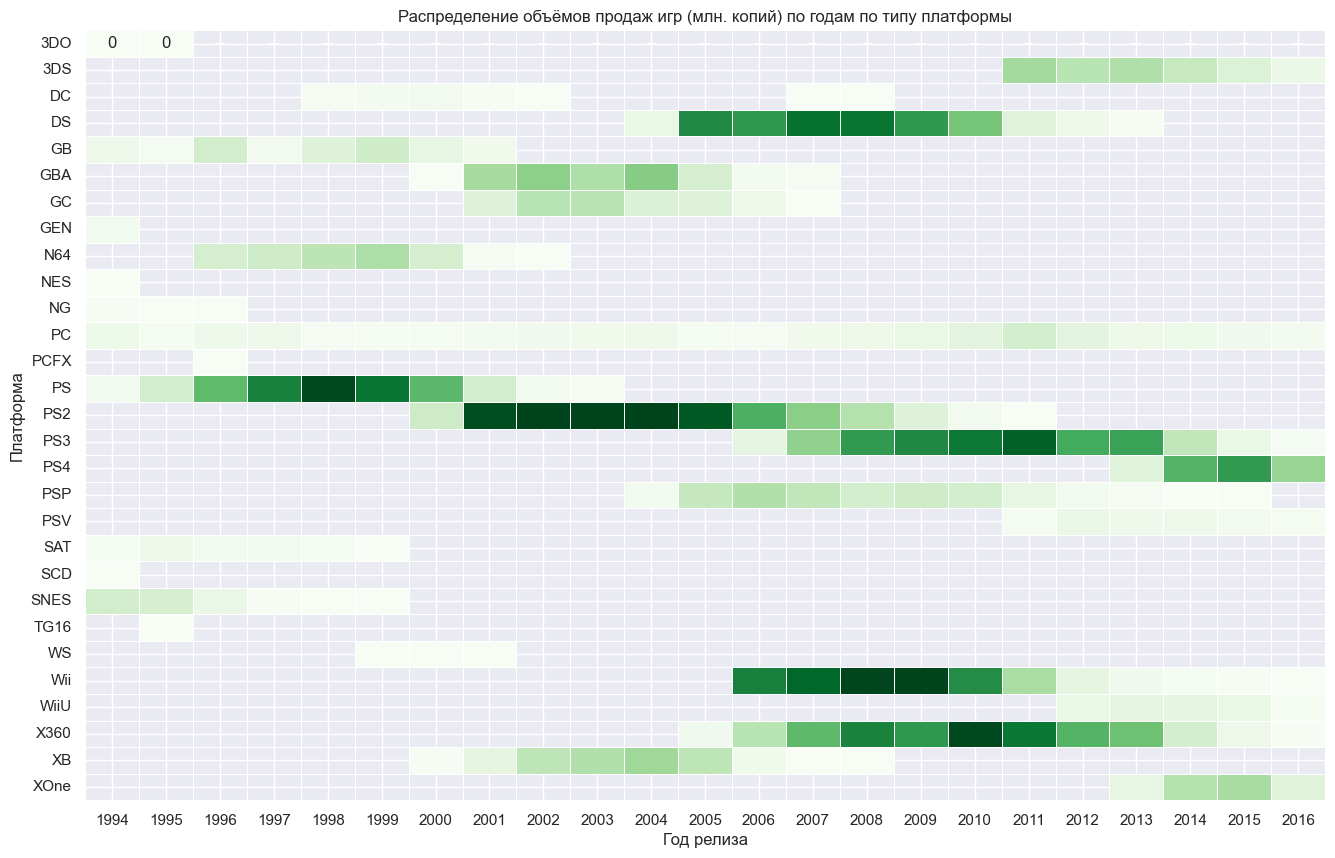

In [47]:
plt.figure(figsize=(16, 10))
sns.heatmap(data=platforms_sum, annot=True, cbar=False, robust=True, linewidths=.5, fmt='.0f', cmap='Greens')
plt.title('Распределение объёмов продаж игр (млн. копий) по годам по типу платформы')
plt.xlabel('Год релиза')
plt.ylabel('Платформа')
plt.show()

1) У всех популярных платформ пик приходится примерно на середину существования.  
2) Разные платформы имеют разную продолжительность существования. Например, максимальная продолжительность существования у платформы PC, которая за рассматриваемые период популярна во все года (на протяжении 23 лет подряд). Минимальная продолжительность существования в 1 год у платформы TG16 и GEN.  
3) Есть платформы, которые имеют перерывы активности(DC). Все остальные платформы за рассматриваемый период "проживают" свой период популярности без перерывов.

Выведем топ-10 платформ по объёму продаж за всё время

In [48]:
top_platforms = df.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False)

top_platforms = top_platforms.head(10).reset_index()
top_platforms

,platform,total_sales
0,PS2,1233.56
1,X360,961.24
2,PS3,931.33
3,Wii,891.18
4,DS,802.78
5,PS,727.58
6,PS4,314.14
7,GBA,312.88
8,PSP,289.53
9,3DS,257.81


Построим графики объёмов продаж для каждой платформы из топ-10 для того, чтобы оценить "живучесть" платформ

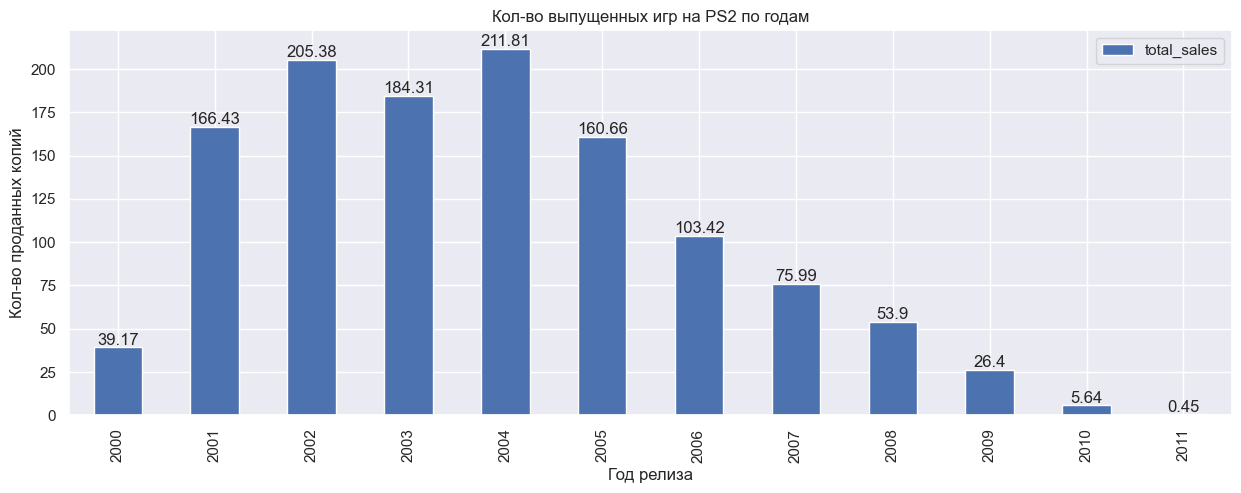

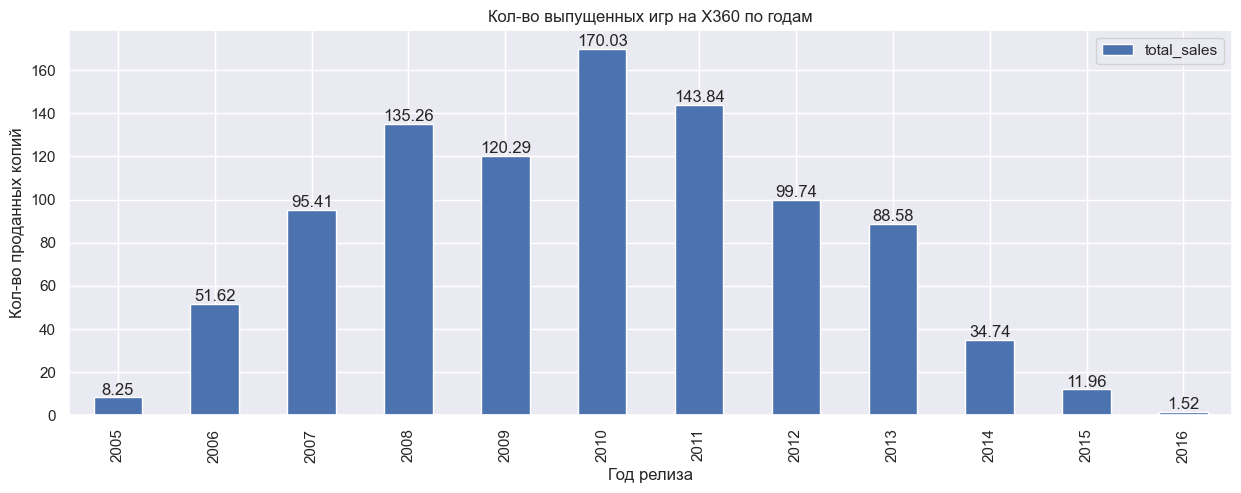

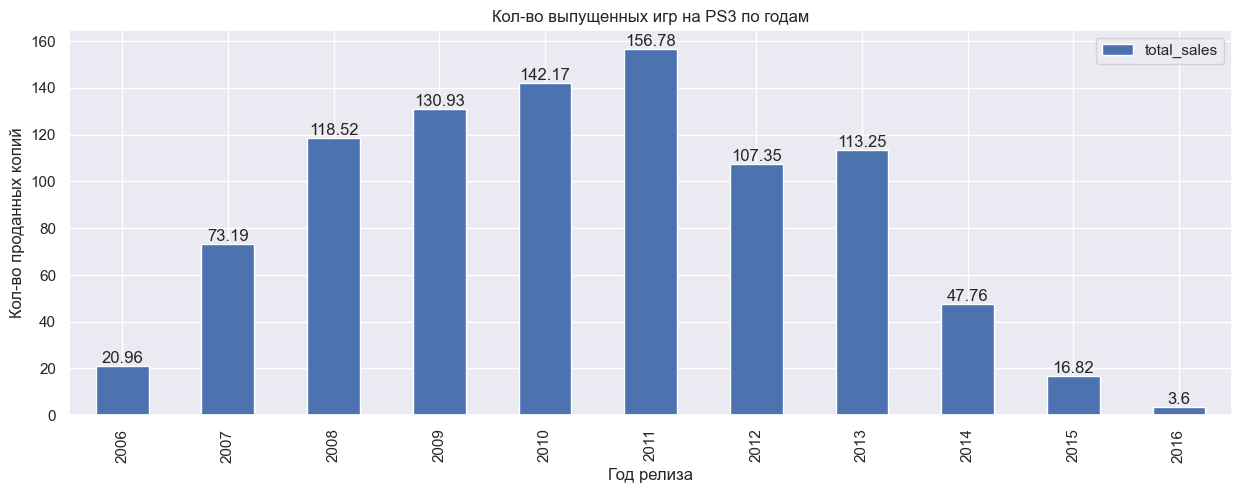

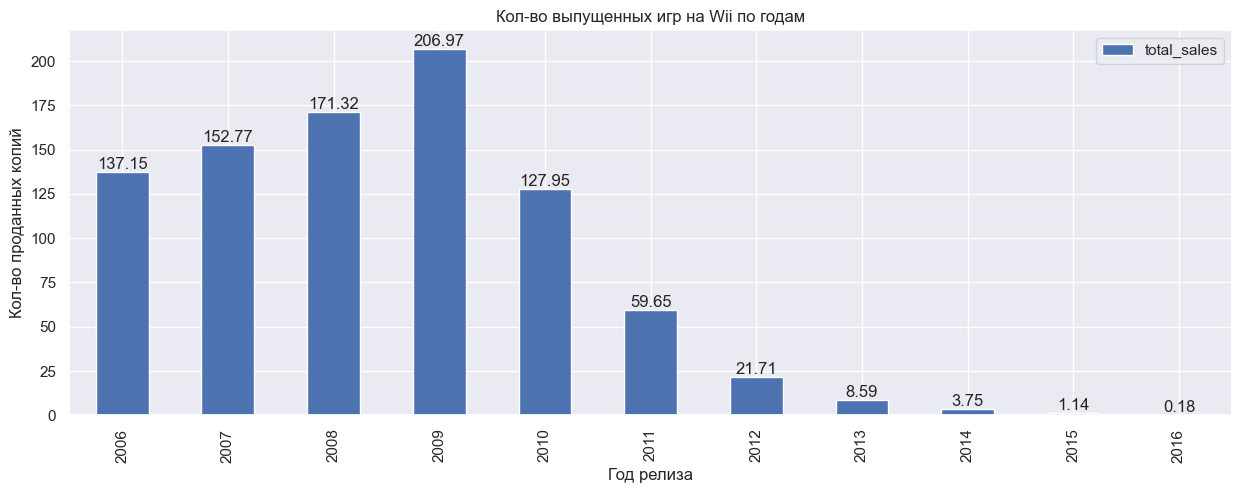

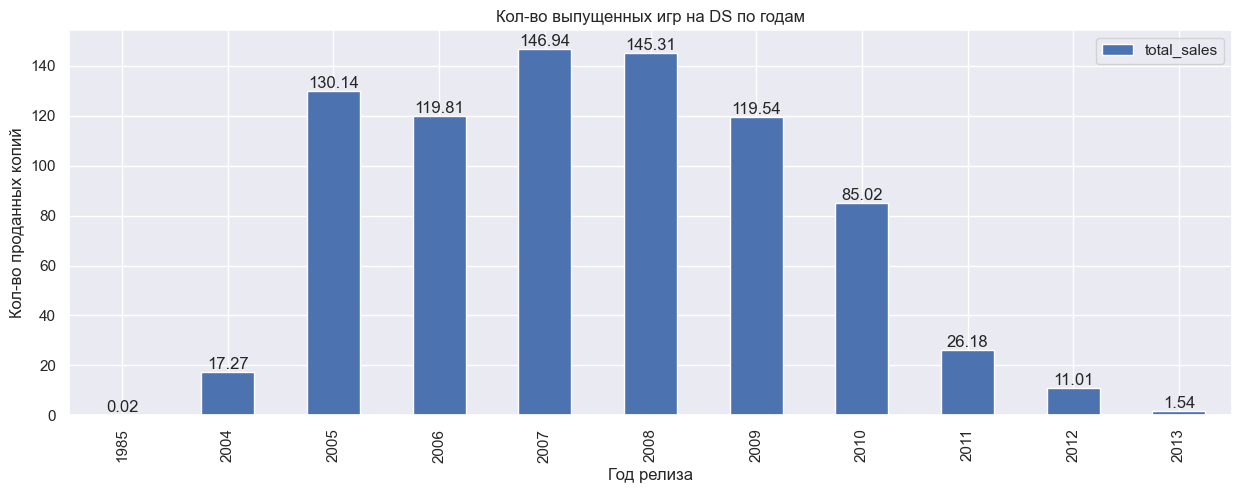

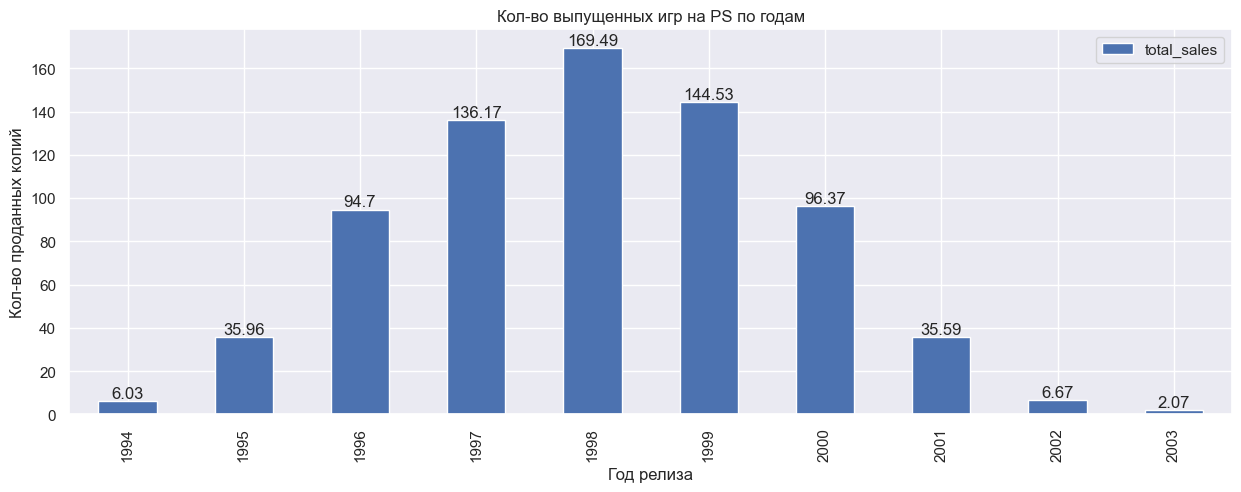

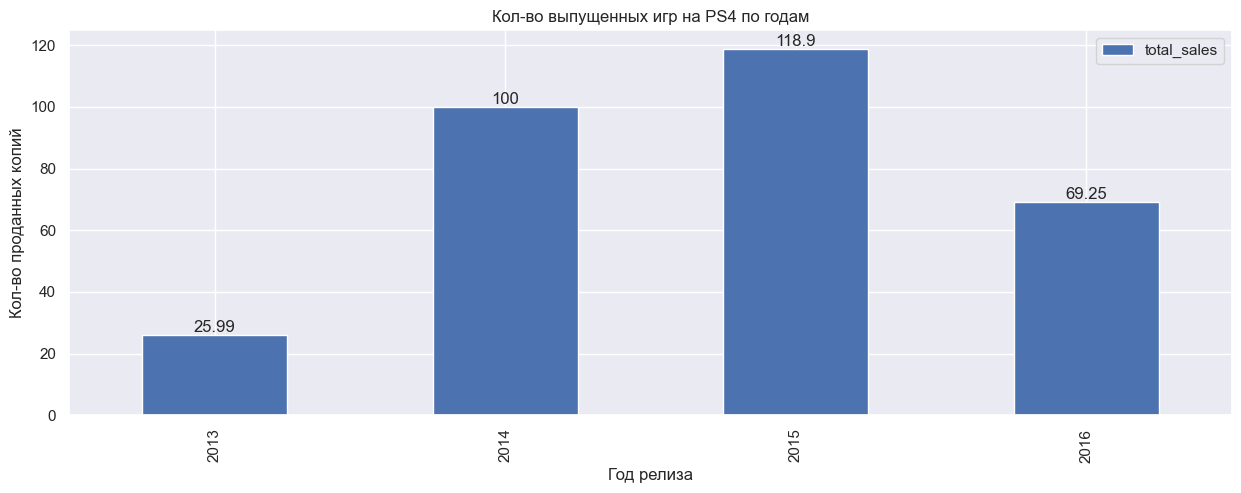

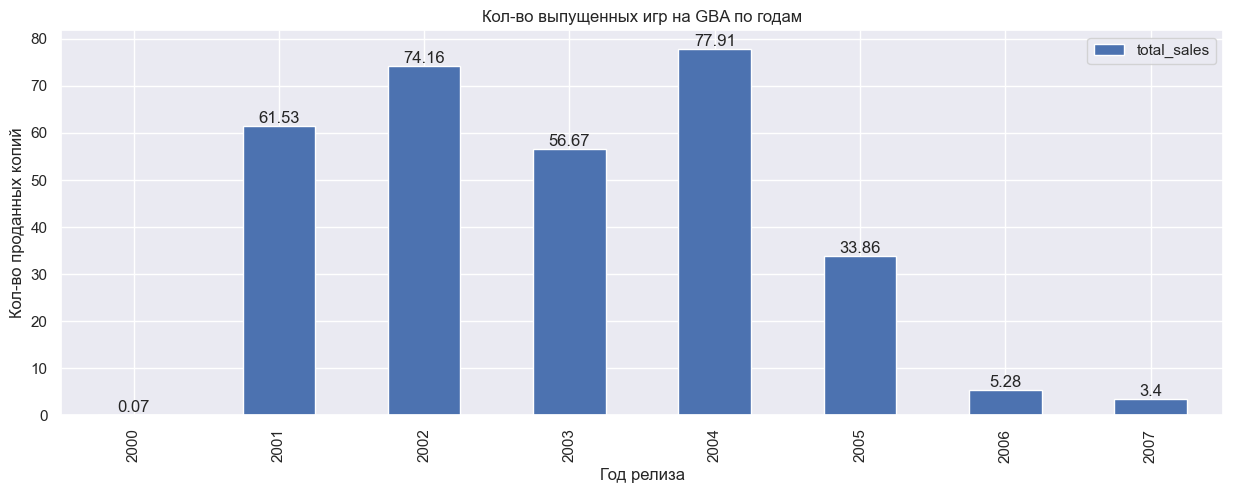

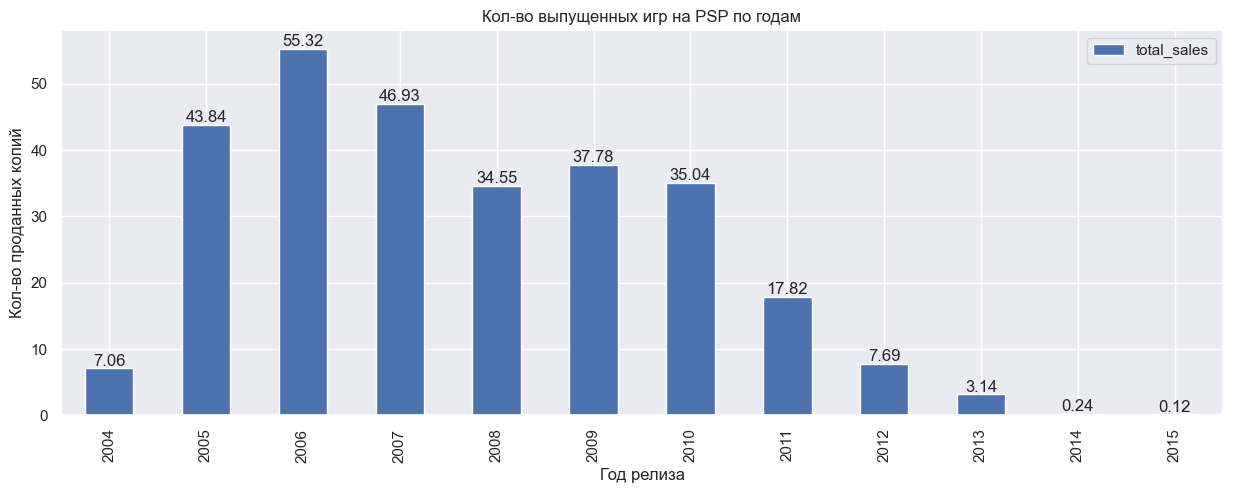

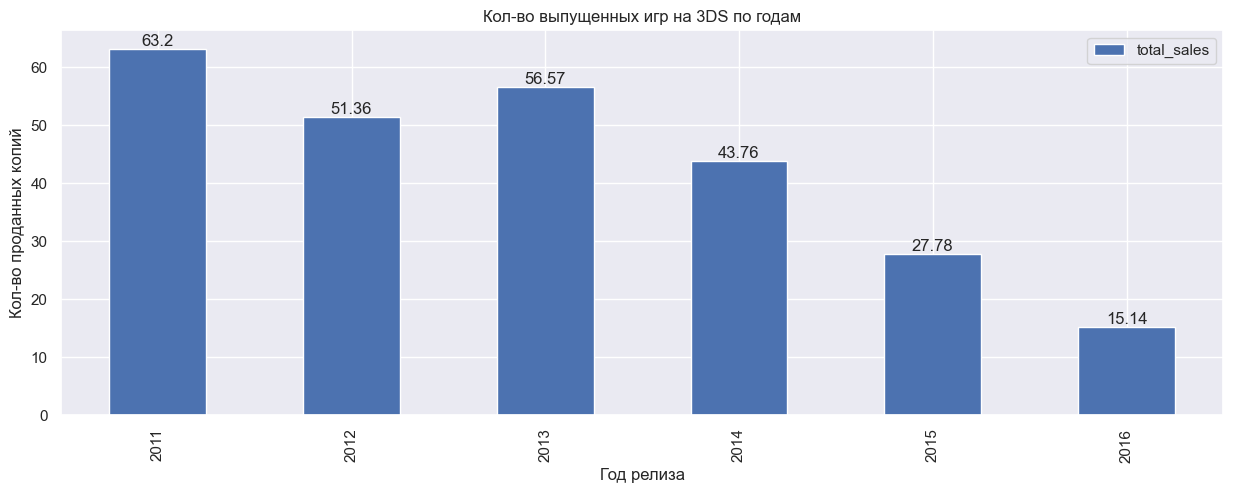

In [49]:
top_dict = top_platforms['platform'].unique()

for platform in top_dict:
    ax = df[df['platform'] == platform].pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').plot(kind='bar', figsize=(15,5))
    ax.bar_label(ax.containers[0])
    plt.title(f'Кол-во выпущенных игр на {platform} по годам')
    plt.xlabel('Год релиза')
    plt.ylabel('Кол-во проданных копий')

Среди вышеуказанных период жизни платформ чаще всего составляет около 10 лет

In [50]:
# проверим период жизни платформы другим способом
lifetime = df.pivot_table(index='platform', values='year_of_release', aggfunc=['min', 'max']).reset_index()

# переименуем столбцы для удобства
lifetime.columns = ['platform', 'first', 'last']

# посчитаем разницу и прибавим 1 год, чтобы не было нулей
lifetime['period'] = (lifetime['last'] - lifetime['first']) + 1

Выведем таблицу жизненного период различных платформ

In [51]:
lifetime

,platform,first,last,period
0,2600,1980,1989,10
1,3DO,1994,1995,2
2,3DS,2011,2016,6
3,DC,1998,2008,11
4,DS,1985,2013,29
5,GB,1988,2001,14
6,GBA,2000,2007,8
7,GC,2001,2007,7
8,GEN,1990,1994,5
9,GG,1992,1992,1


Отобразим описательную статистику

In [52]:
lifetime['period'].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

count   31.00
mean     8.61
std      7.00
min      1.00
1%       1.00
5%       1.00
25%      4.00
50%      7.00
75%     11.00
95%     21.50
99%     31.10
max     32.00
Name: period, dtype: float64

Отобразим моду

In [53]:
lifetime['period'].mode()

0    12
Name: period, dtype: int32

Посмотрим на описательную статистику без учёта исключительных долгожителей: ПК и DS, а также отсечём 2016 год для того, чтобы выявить уже "мертвые" платформы и отсечь недавно появившиеся

In [54]:
lifetime.query('period < 28 and last < 2016').describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

,first,last,period
count,21.00,21.00,21.00
mean,1994.29,2000.29,7.00
std,5.90,6.94,4.24
min,1980.00,1989.00,1.00
1%,1980.60,1989.60,1.00
5%,1983.00,1992.00,1.00
25%,1992.00,1995.00,3.00
50%,1994.00,1999.00,7.00
75%,1999.00,2007.00,10.00
95%,2001.00,2011.00,12.00


Построим диаграмму размаха для датафрейма с продолжительностью жизни платформ

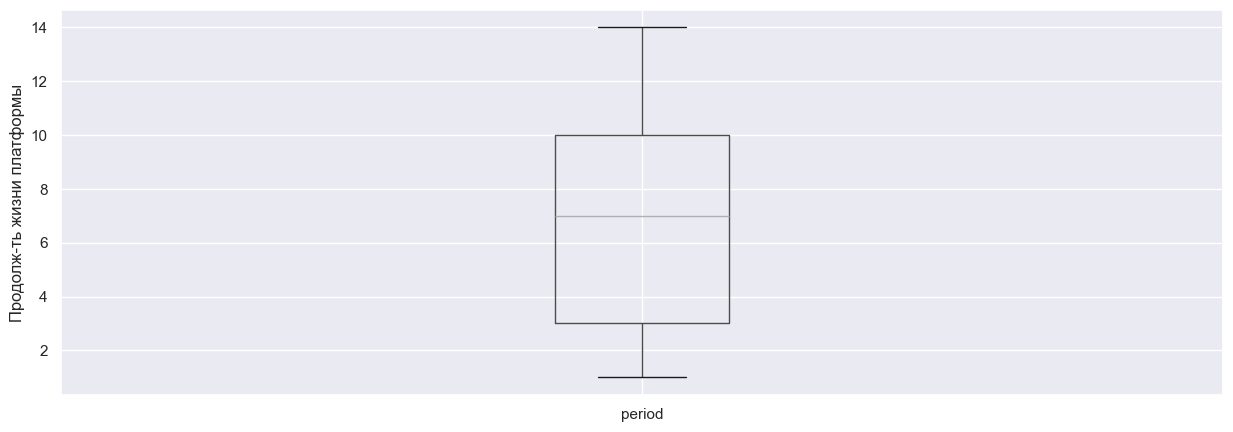

In [55]:
lifetime.query('period < 28 and last < 2016').boxplot(column='period', grid=True, figsize=(15,5))
plt.ylabel('Продолж-ть жизни платформы')
plt.show()

Среднее значения равно 7 годам, медиана также равна 7 годам, а мода равна 12 (значение 12 встречается 4 раза). По графикам выше видно, что наиболее популярные платформы, в основном, имеют продолжительность жизни около 10 лет.

Таким образом, что среднее время периода жизни платформы составляет 7 лет.

### Определим актуальной временной период

***Мы определили, что период до 1994 года статистически нас не интересует. Помимо этого, выявлено, что средняя продолжительность жизни платформы составляет 7 лет, а у популярных платформ значение часто достигает 10 лет.\
Однако, стоит учесть, что среди представленных платформ большая часть оставила позади свои лучшие годы, а потому осталось немного подающих надежд платформ. Среди них представлены такие, как PS4, XOne, WiiU, PSV, PS4, 3DS, существующие примерно с 2011 года, а также бессмертный ПК. Учитывая высокую динамичность рынка видеоигр, сократим анализируемый период до 3-х лет.\
Исходя из вышепредставленных выводов, нас интересует период с 2014 по 2016 гг.***

Создадим срез данных по актуальному периоду в 3 года, предшествующих 2017-му году

In [56]:
relevant = df.query('year_of_release > 2013')
relevant = relevant.reset_index(drop=True)

Выведем основную информацию о новом датафрейме и первые строки

In [57]:
relevant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1689 entries, 0 to 1688
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             1689 non-null   object 
 1   platform         1689 non-null   object 
 2   year_of_release  1689 non-null   int32  
 3   genre            1689 non-null   object 
 4   na_sales         1689 non-null   float64
 5   eu_sales         1689 non-null   float64
 6   jp_sales         1689 non-null   float64
 7   other_sales      1689 non-null   float64
 8   critic_score     718 non-null    float64
 9   user_score       888 non-null    float64
 10  rating           1689 non-null   object 
 11  total_sales      1689 non-null   float64
 12  platform_type    1689 non-null   object 
dtypes: float64(7), int32(1), object(5)
memory usage: 165.1+ KB


In [58]:
relevant.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,platform_type
0,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,ND,14.63,Консоль
1,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.00,8.30,M,12.62,Консоль
2,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,ND,11.68,Мобильная
3,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.00,4.30,E,8.58,Консоль
4,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,ND,7.98,Консоль


### Какие платформы лидируют по продажам, растут или падают? Выберем несколько потенциально прибыльных платформ.

Отобразим таблицу объёмов продаж по платформам за 2014-2016 гг.

In [59]:
top = relevant.pivot_table(index='platform',columns='year_of_release',\
                           values='total_sales', aggfunc='sum')
top

year_of_release,2014,2015,2016
platform,,,
3DS,43.76,27.78,15.14
PC,13.28,8.52,5.25
PS3,47.76,16.82,3.60
PS4,100.00,118.90,69.25
PSP,0.24,0.12,NaN
PSV,11.90,6.25,4.25
Wii,3.75,1.14,0.18
WiiU,22.03,16.35,4.60
X360,34.74,11.96,1.52


Сразу отсечём платформы, для которых не продавались игры в последние годы, а также те, продажи которых почти угасли

In [60]:
top = top.query("platform not in ['DS', 'PS2', 'PSP', 'Wii', 'X360']")

Отобразим обновлённую сводную таблицу и построим по ней график

year_of_release,2014,2015,2016
platform,,,
3DS,43.76,27.78,15.14
PC,13.28,8.52,5.25
PS3,47.76,16.82,3.60
PS4,100.00,118.90,69.25
PSV,11.90,6.25,4.25
WiiU,22.03,16.35,4.60
XOne,54.07,60.14,26.15


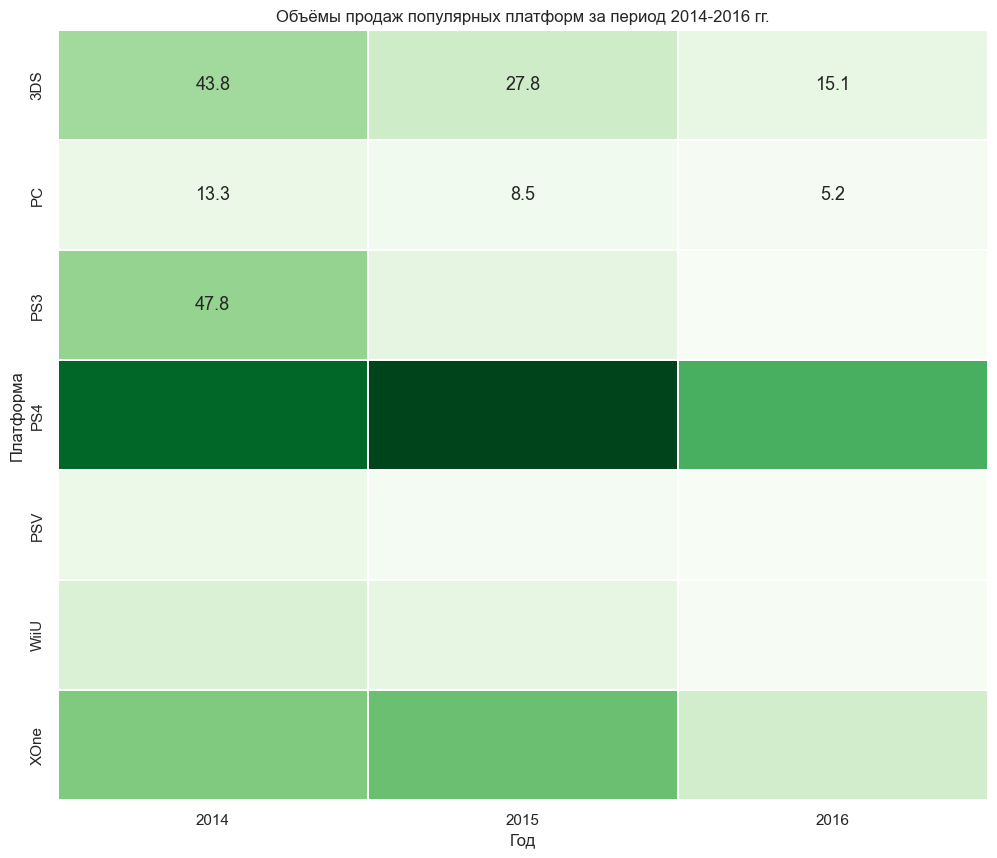

In [61]:
display(top)

plt.figure(figsize=(12, 10))
sns.heatmap(top, annot=True, annot_kws={"size":13}, fmt=".1f", cmap='Greens', cbar=False, robust=True, linewidths=0.3)
plt.title('Объёмы продаж популярных платформ за период 2014-2016 гг.')
plt.ylabel('Платформа')
plt.xlabel('Год')
plt.show()

Посмотрим на общий объём продаж у выбранных платформ за интересующий период

In [62]:
display(top.sum(axis=1).sort_values(ascending=False))

platform
PS4    288.15
XOne   140.36
3DS     86.68
PS3     68.18
WiiU    42.98
PC      27.05
PSV     22.40
dtype: float64

**Вывод:**  
Исходя из анализа, перспективными платформами являются: 3DS, PC, PS4, XOne.  
Такие платформы, как X360 и PS3 находятся на закате своего жизненного периода, и, хотя для них еще продают приличное кол-во игр по состоянию на 2016 год, в 2017 году ситуация может сильно измениться, поскольку выпущены их более популярные преемники - XOne и PS4 соответственно, также угасающими являются платформы PSV и WiiU.

### «Ящик с усами» по глобальным продажам игр в разбивке по платформам.

Построим диаграммы размаха

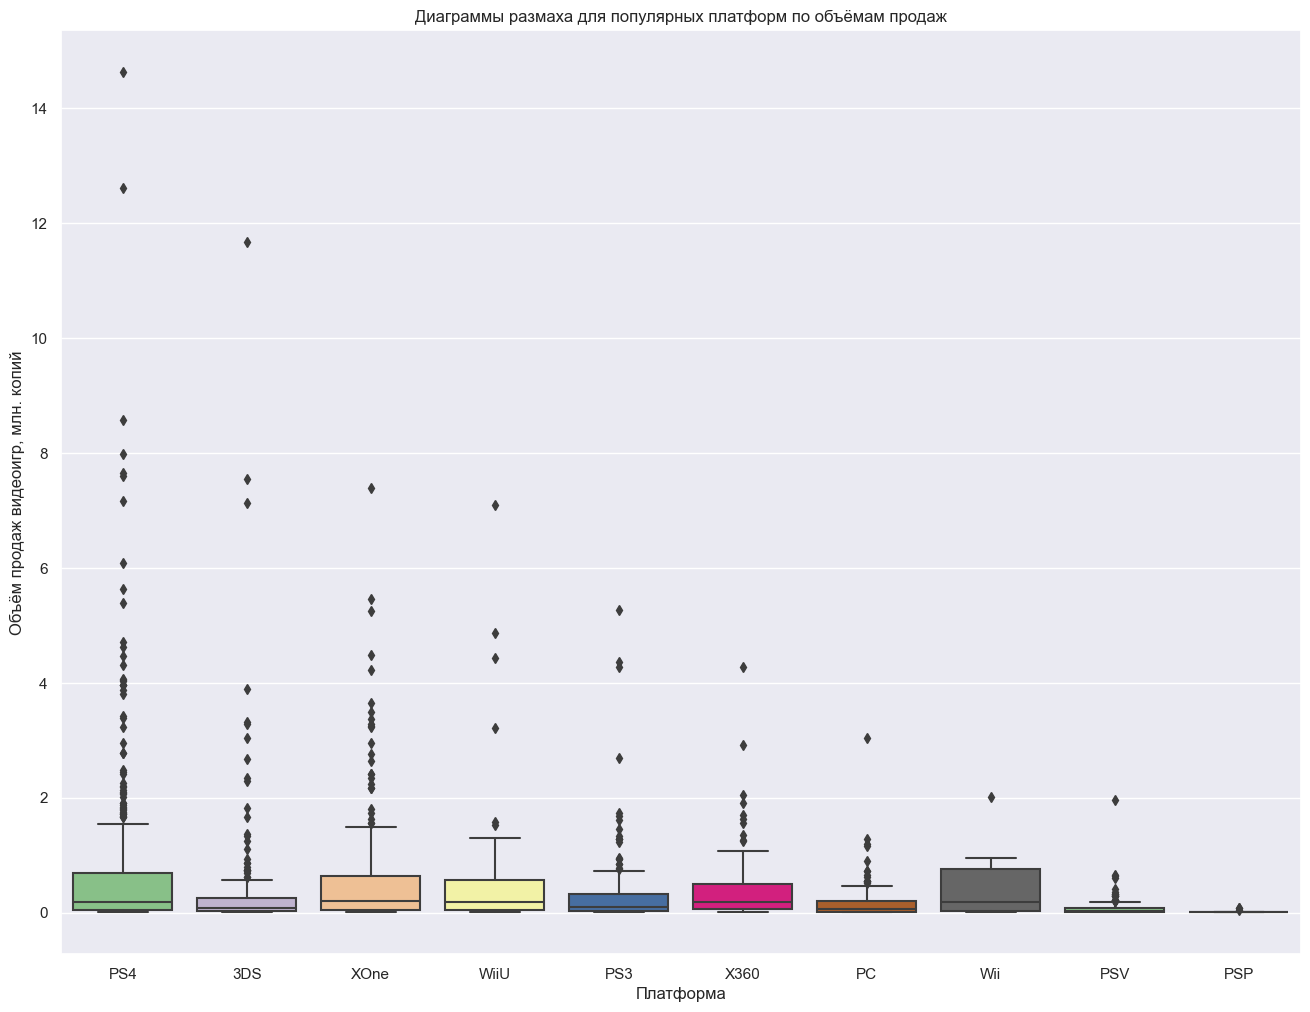

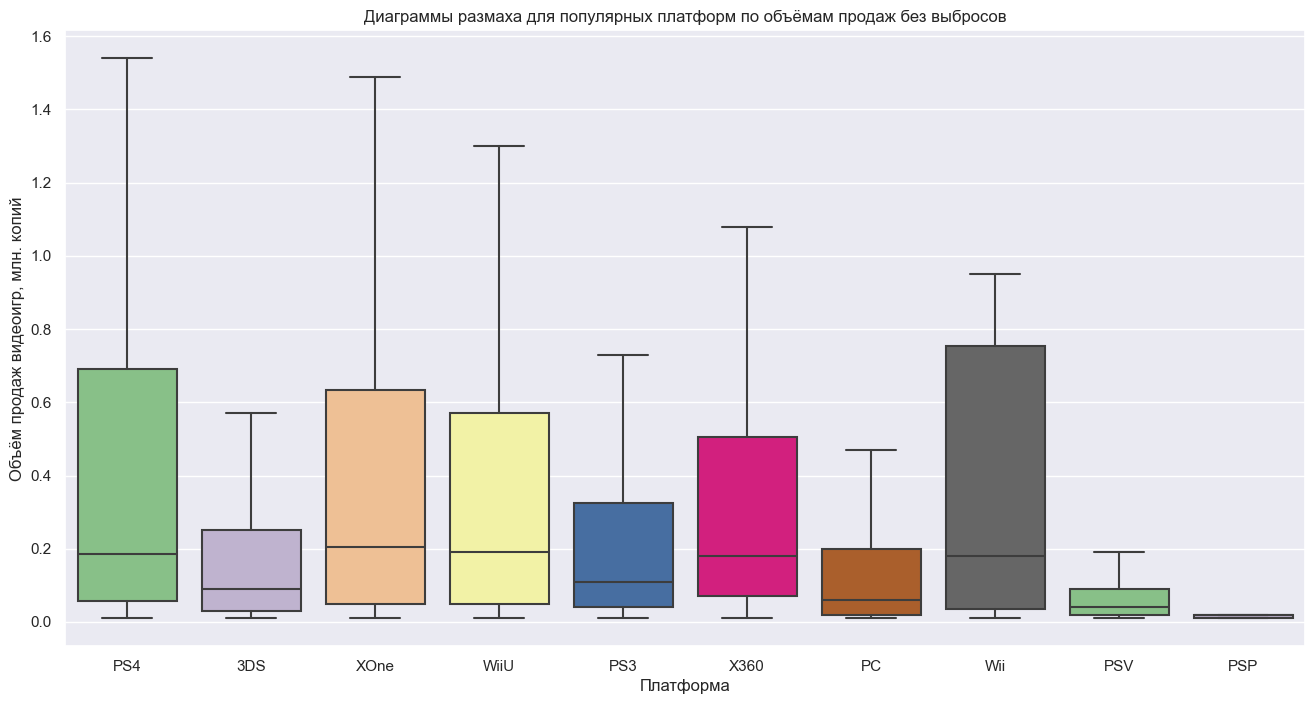

In [63]:
plt.figure(figsize=(16,12))
sns.boxplot(x="platform", y="total_sales", data = relevant, palette='Accent')
plt.title('Диаграммы размаха для популярных платформ по объёмам продаж')
plt.ylabel('Объём продаж видеоигр, млн. копий')
plt.xlabel('Платформа')
plt.show()

plt.figure(figsize=(16,8))
sns.boxplot(x="platform", y="total_sales", data = relevant, palette='Accent', showfliers=False)
plt.title('Диаграммы размаха для популярных платформ по объёмам продаж без выбросов')
plt.ylabel('Объём продаж видеоигр, млн. копий')
plt.xlabel('Платформа')
plt.show()

**Вывод:**  
1) Самая хитовая игра (15 млн. продаж) представлена у PS4. Она также лидируют по кол-ву хитов вообще(учитывая кол-во выбросов).  
2) Наибольшие медианы принадлежат PS4, XOne и WiiU. Наибольший межквартильный размах среди популярных - у PS4 и XOne, причём у первой он немного больше.  
3) Среди популярных платформ меньше всего хитов у PSV И WiiU.

### Как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. 

Отобразим распределение платформ

In [64]:
relevant['platform'].value_counts()

platform
PS4     376
PSV     295
XOne    228
PS3     219
3DS     212
PC      151
X360    111
WiiU     73
PSP      13
Wii      11
Name: count, dtype: int64

В качестве популярной платформы возьмём PS4.

In [65]:
ps = relevant[['platform', 'critic_score', 'user_score', 'total_sales']].query('platform == "PS4"')
ps = ps.drop('platform', axis=1)

In [66]:
ps

,critic_score,user_score,total_sales
0,NaN,NaN,14.63
1,97.00,8.30,12.62
3,82.00,4.30,8.58
4,NaN,NaN,7.98
5,83.00,5.70,7.66
...,...,...,...
1627,69.00,7.50,0.01
1629,NaN,NaN,0.01
1636,61.00,7.90,0.01
1637,51.00,5.50,0.01


**Построим график зависимости объёма продаж от оценки критиков**

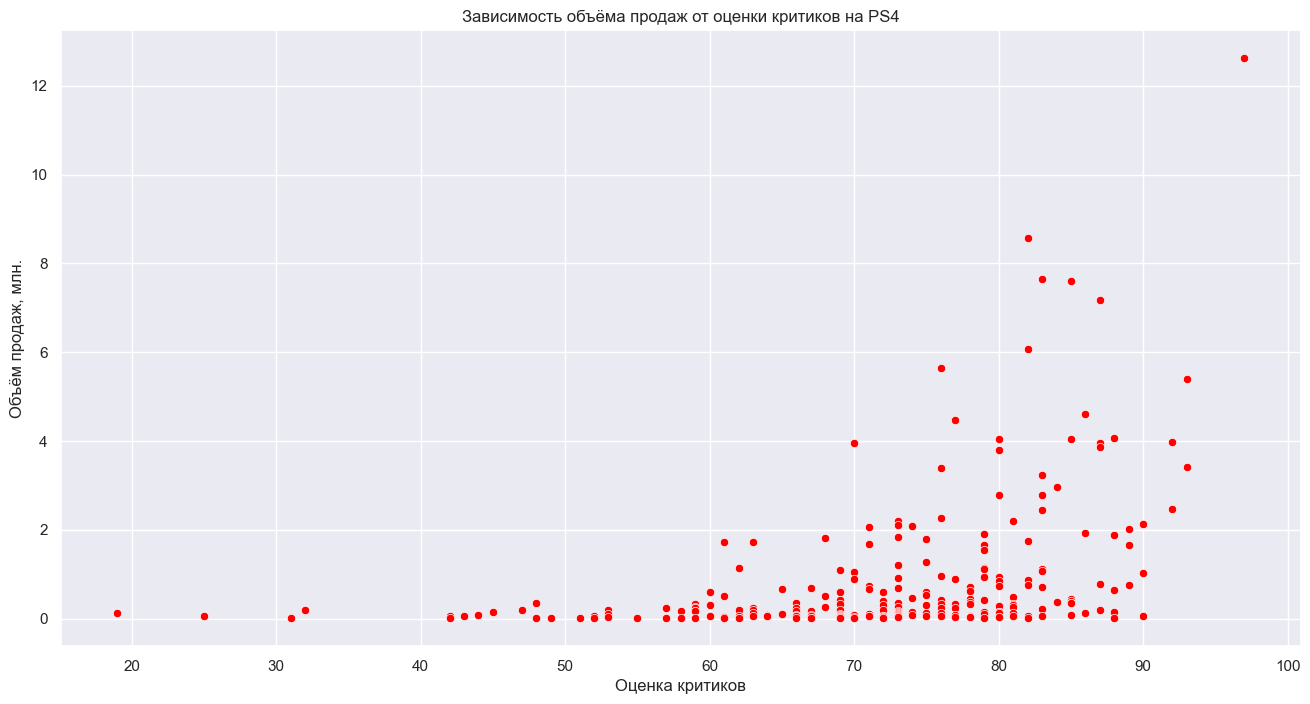

In [67]:
plt.figure(figsize=(16,8))
sns.scatterplot(data=ps, y='total_sales', x='critic_score', color='red')
plt.title('Зависимость объёма продаж от оценки критиков на PS4')
plt.ylabel('Объём продаж, млн.')
plt.xlabel('Оценка критиков')
plt.show()

**Построим график зависимости объёма продаж от оценки игроков**

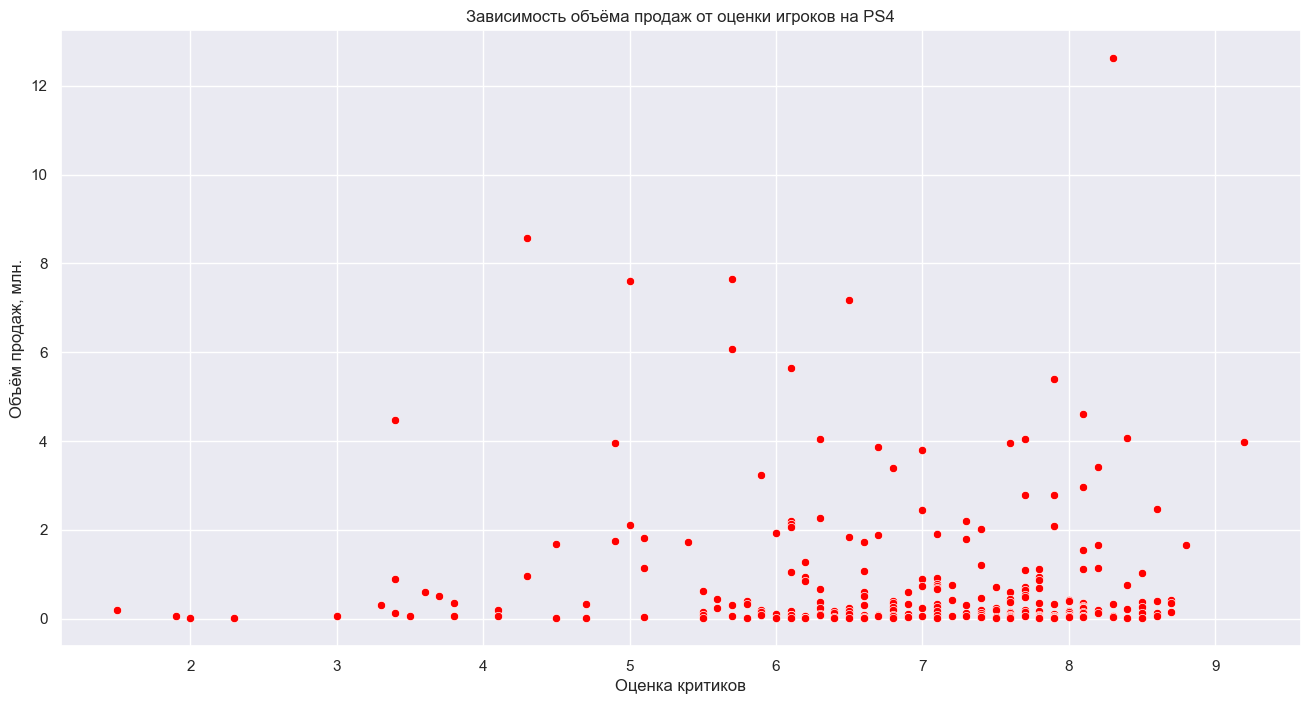

In [68]:
plt.figure(figsize=(16,8))
sns.scatterplot(data=ps, y='total_sales', x='user_score', color='red')
plt.title('Зависимость объёма продаж от оценки игроков на PS4')
plt.ylabel('Объём продаж, млн.')
plt.xlabel('Оценка критиков')
plt.show()

**Отобразим корреляционную матрицу влияния оценок критиков и игроков на объём продаж**

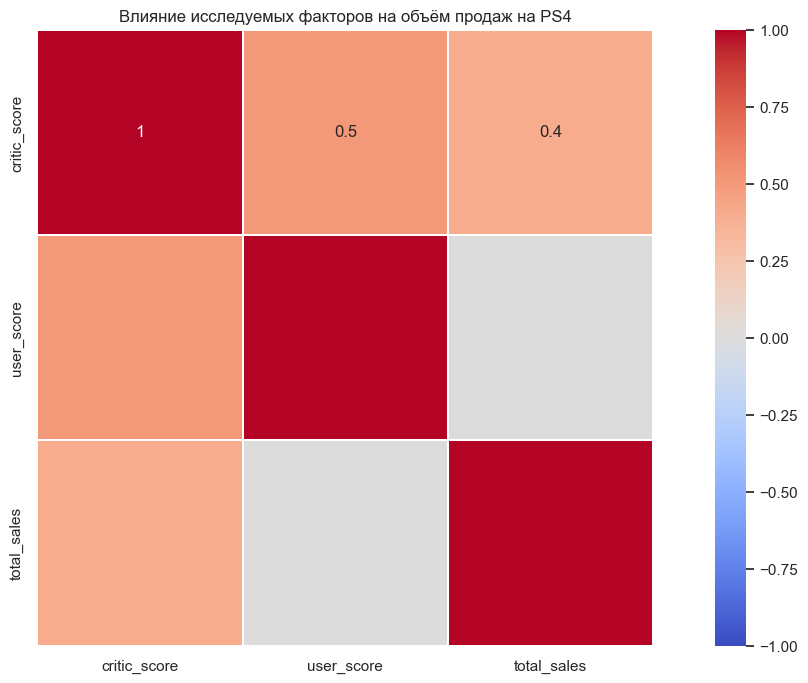

In [69]:
plt.figure(figsize=(16,8))
sns.heatmap(ps.corr().round(1), annot=True, cmap='coolwarm', square=True, linewidth=.1,robust=True, vmin=-1)
plt.title(f'Влияние исследуемых факторов на объём продаж на PS4')
plt.show()

In [70]:
ps.corr()

,critic_score,user_score,total_sales
critic_score,1.00,0.55,0.40
user_score,0.55,1.00,-0.04
total_sales,0.40,-0.04,1.00


**Вывод:**  
1) Наблюдаем небольшую линейную корреляцию между оценками критиков и объёмами продаж. В целом, по графику видно, что с ростом оценки критиков растёт и объём продаж.  
2) Никаким образом на объём продаж не влияет оценка игроков, что видно и по графику, поскольку все значения приближены к оси абсцисс.

##### Соотнесём выводы с продажами игр на других платформах.

Выведем корреляционную матрицу влияния оценок критиков и оценок игроков на объёмы продаж видеоигр по каждой из оставшихся платформ

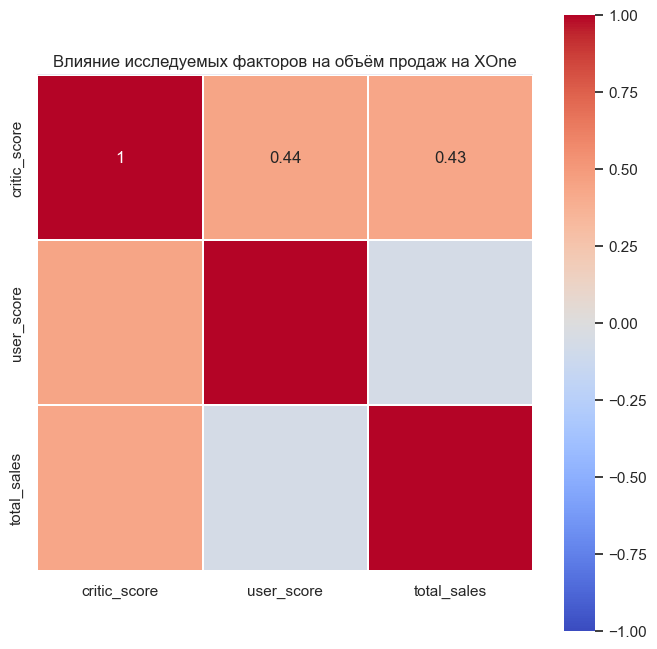

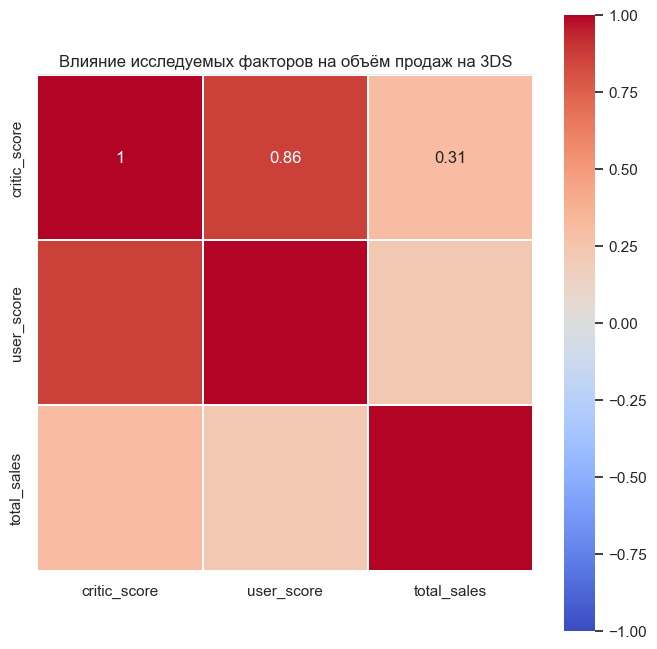

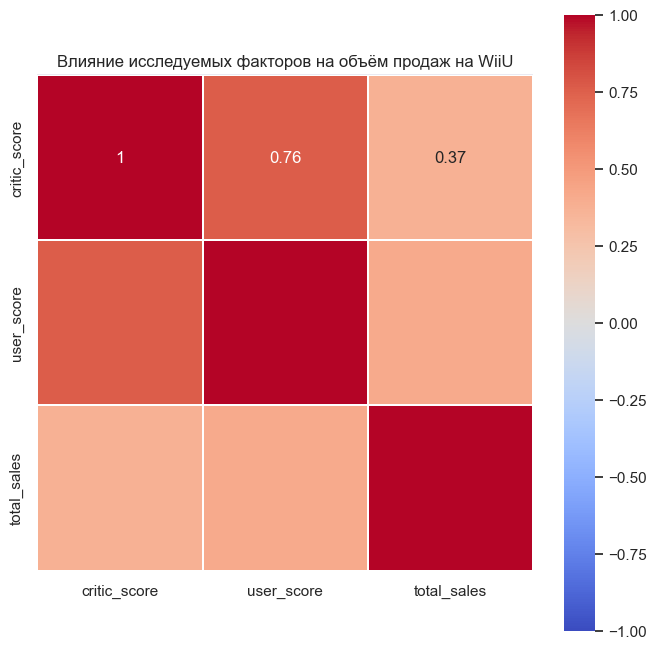

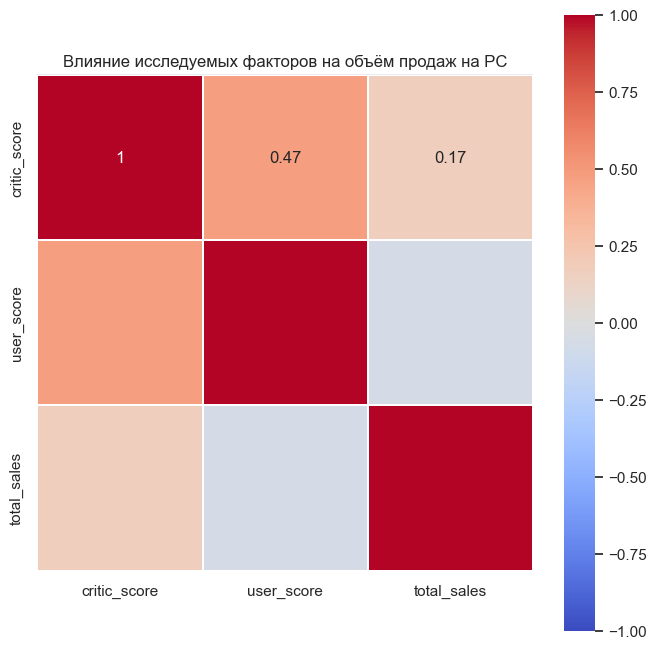

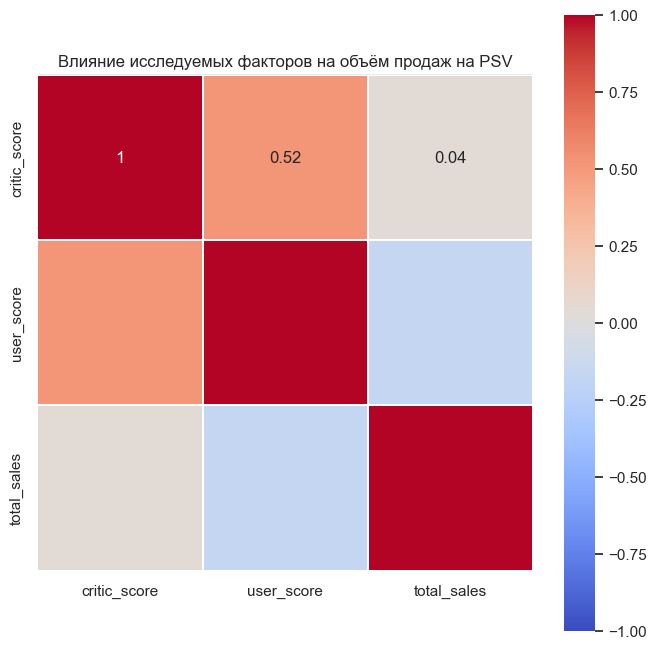

In [71]:
# построим корр. матрицы для остальных платформ с помощью цикла
for pf in['XOne', "3DS", "WiiU", "PC", "PSV"]:
    plt.figure(figsize=(8,8))
    relevant_corr_matrix = relevant[['platform', 'critic_score', 'user_score', 'total_sales']].query('platform == @pf')
    (sns.heatmap(relevant_corr_matrix.reset_index(drop=True)
                 .drop('platform', axis=1)
                 .corr()
                 .round(2)
                 , annot=True, cmap='coolwarm', square=True, linewidth=.1, vmin=-1)
    )
    plt.title(f'Влияние исследуемых факторов на объём продаж на {pf}')
    plt.show()

Построим график влияния оценки критиков на результат для оставшихся платформ

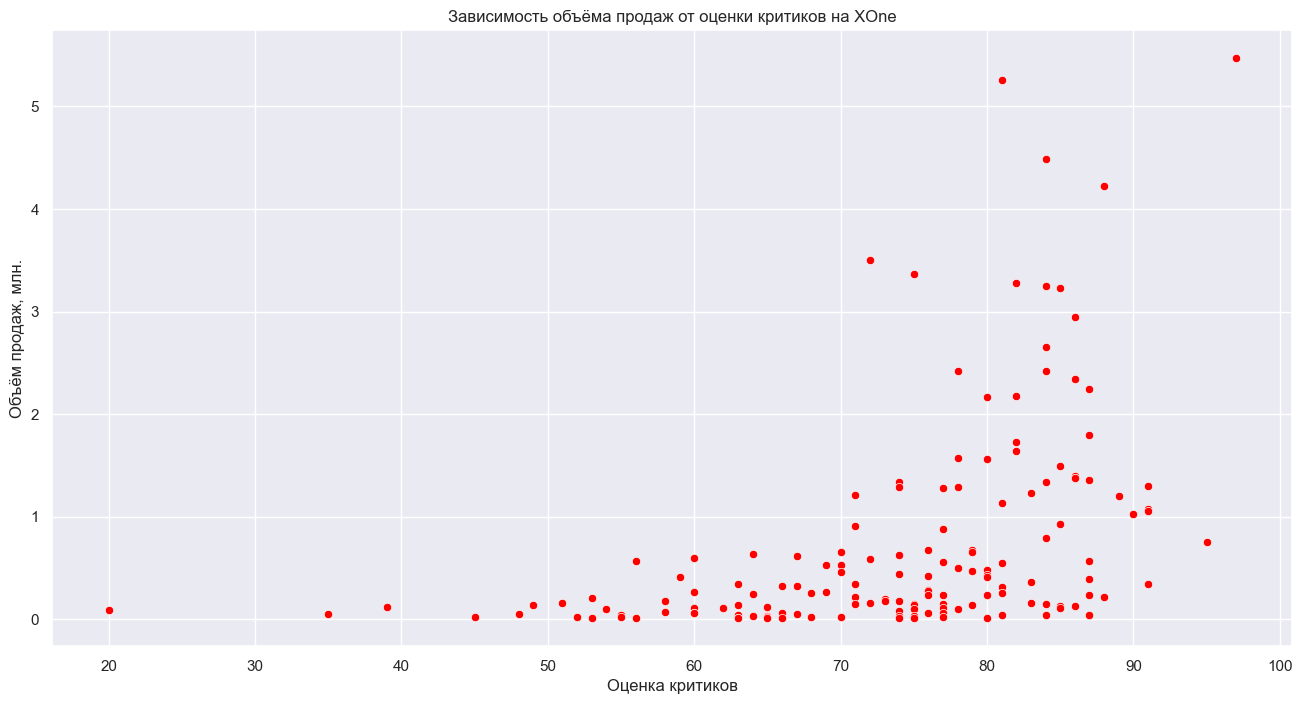

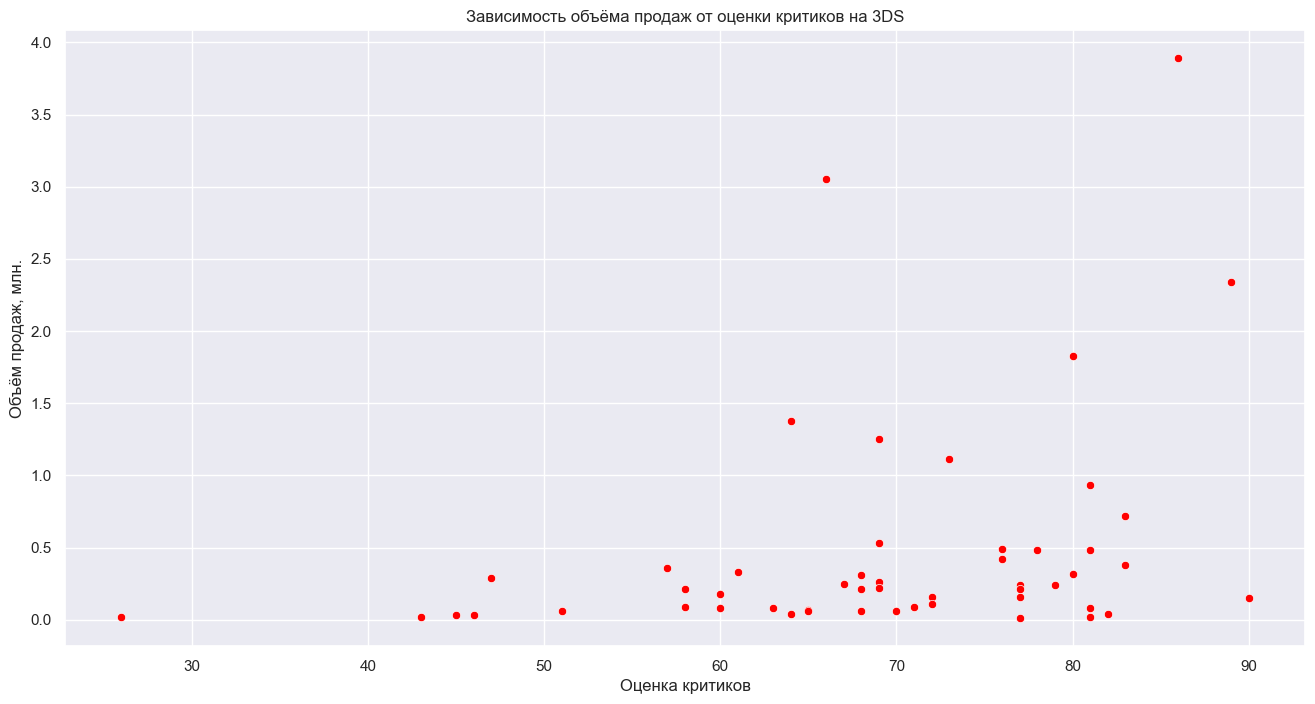

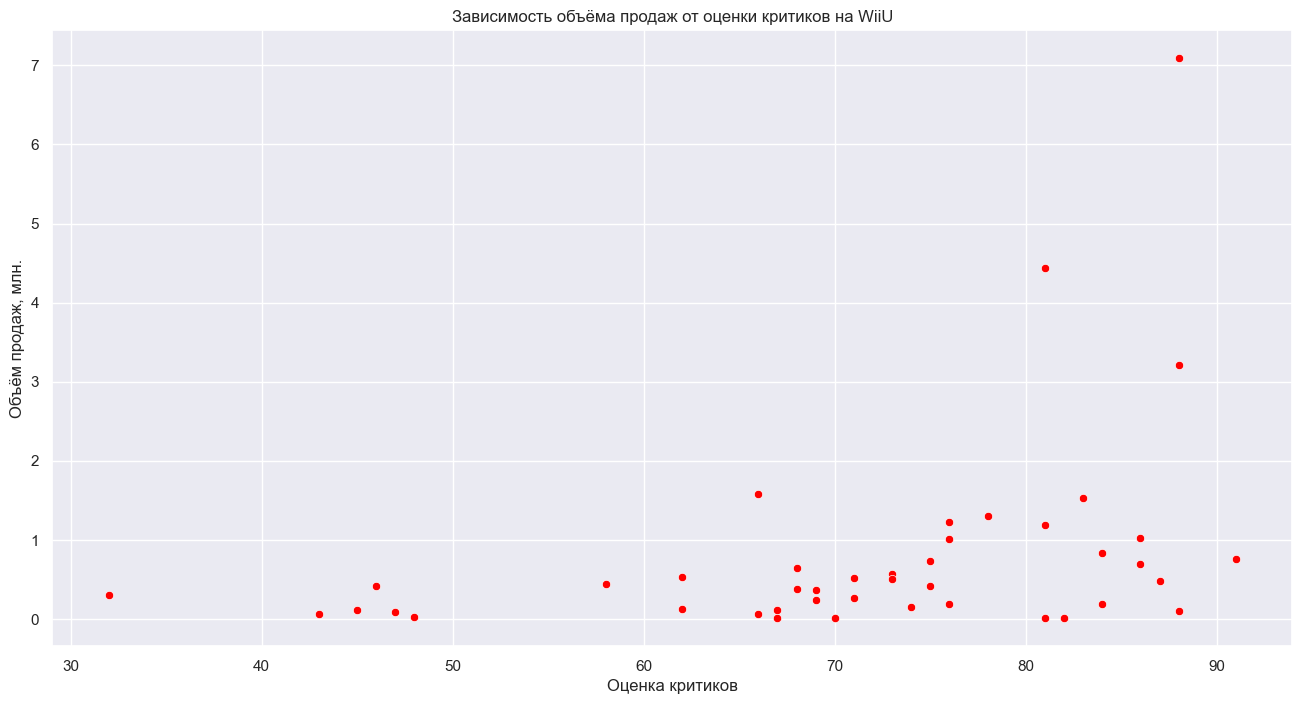

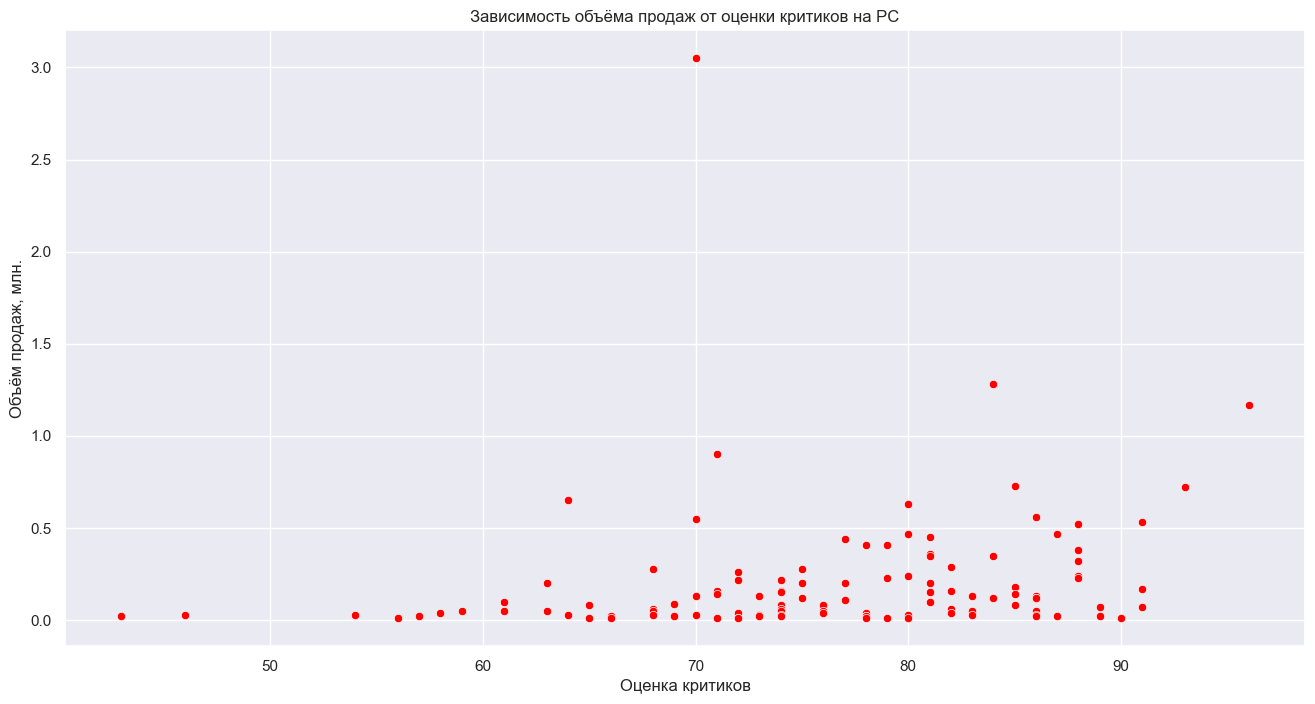

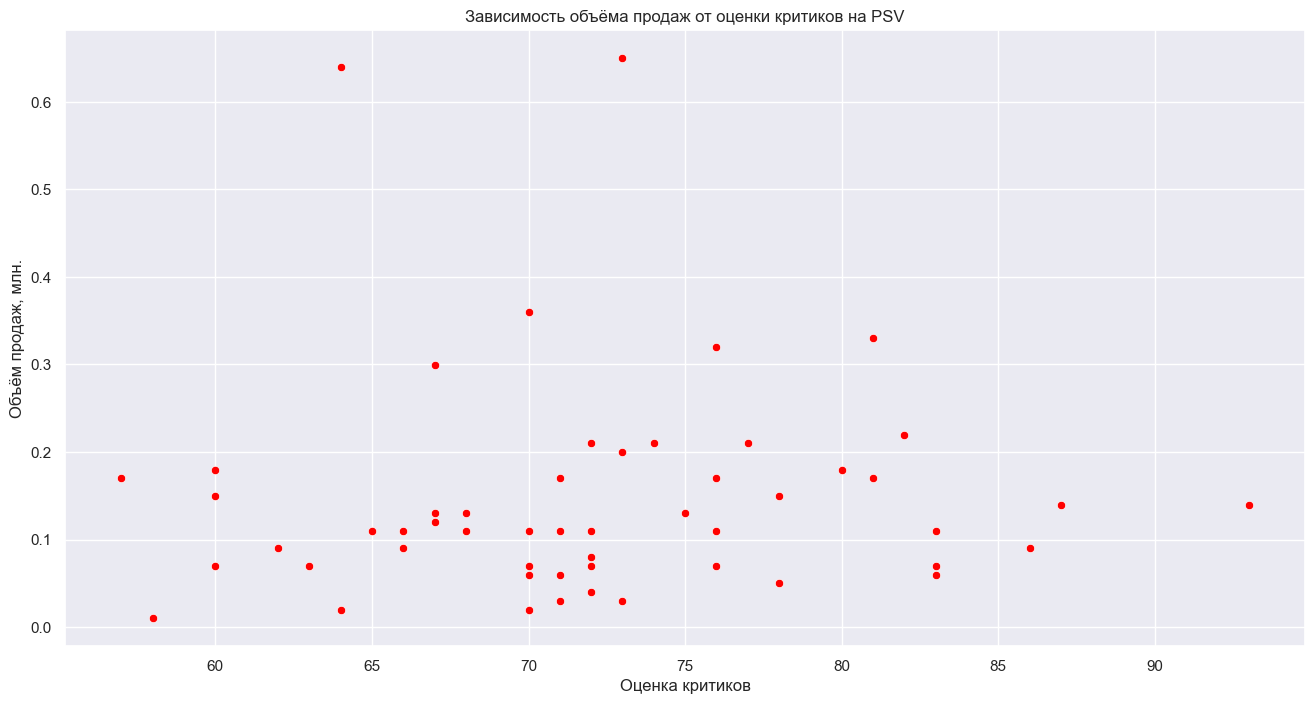

In [72]:
def build_scatter():
    for pf in["XOne", "3DS", "WiiU", "PC", "PSV"]:
        plt.figure(figsize=(16,8))
        sns.scatterplot(data=relevant[['platform', 'critic_score', 'user_score', 'total_sales']]\
                        .query('platform == @pf'),\
                        y='total_sales', x='critic_score', color='red')
    
        plt.title(f'Зависимость объёма продаж от оценки критиков на {pf}')
        plt.ylabel('Объём продаж, млн.')
        plt.xlabel('Оценка критиков')
        plt.show()
        
build_scatter()

**Вывод:**  
1) Для платформы XOne характерно наличие небольшой прямой связи (0.43) оценок критиков на объём продаж. Оценка игроков на результат никак не влияет.  
2) Для платформы 3DS характерно наличие небольшой прямой связи (0.31) оценок критиков на объём продаж. Оценка игроков на результат влияет крайне слабо.  
3) Для платформы WiiU характерно наличие небольшой прямой связи оценок критиков (0.37) и оценок игроков (примерно 0.4) на объём продаж. Причём оценка игроков влияет на результат немного сильнее.  
4) Для платформы PC характерно крайне низкой прямой связи (0.17) оценок критиков на объём продаж. Оценка игроков на результат никак не влияет.  
5) Для платформы PSV характерно, что ни один из факторов не влияет на результат.  
6) Среди платформ 3DS, WiiU и PSV заметна достаточно сильная связь между оценка критиков и оценками игроков.

**Таким образом,** заметна тенденция наличия чуть большего влияния на объёмы продаж у такого параметра, как оценка критиков. Исключением здесь является только платформа WiiU.

##### Посмотрим на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

Выявим общее распределение игр по жанрам

In [73]:
relevant['genre'].value_counts()

genre
Action          619
Role-Playing    221
Adventure       185
Sports          161
Shooter         128
Misc            113
Racing           69
Fighting         60
Simulation       44
Platform         38
Strategy         37
Puzzle           14
Name: count, dtype: int64

Самый популярный жанр - Action, наименее популярный - puzzle.

 Создадим дф с кол-вом релизов видеоигр и объёмом продаж по жанрам

In [74]:
top_genres = relevant.pivot_table(index='genre', values='total_sales', aggfunc={'total_sales':'sum', 'genre':'count'})\
                        .rename(columns={'genre':'releases'})\
                        .sort_values(by='total_sales', ascending=False).reset_index()
top_genres

,genre,releases,total_sales
0,Action,619,199.36
1,Shooter,128,170.94
2,Sports,161,109.48
3,Role-Playing,221,101.44
4,Misc,113,37.55
5,Fighting,60,28.22
6,Racing,69,27.52
7,Platform,38,18.09
8,Adventure,185,17.55
9,Simulation,44,13.13


Посмотрим на описательную статистику

In [75]:
top_genres['total_sales'].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.8, 0.9, 0.95, 0.99])

count    12.00
mean     60.79
std      67.88
min       2.21
1%        2.40
5%        3.17
25%      16.45
50%      27.87
75%     103.45
80%     107.87
90%     164.79
95%     183.73
99%     196.23
max     199.36
Name: total_sales, dtype: float64

**Построим график распределение жанров по объёму продаж видеоигр**

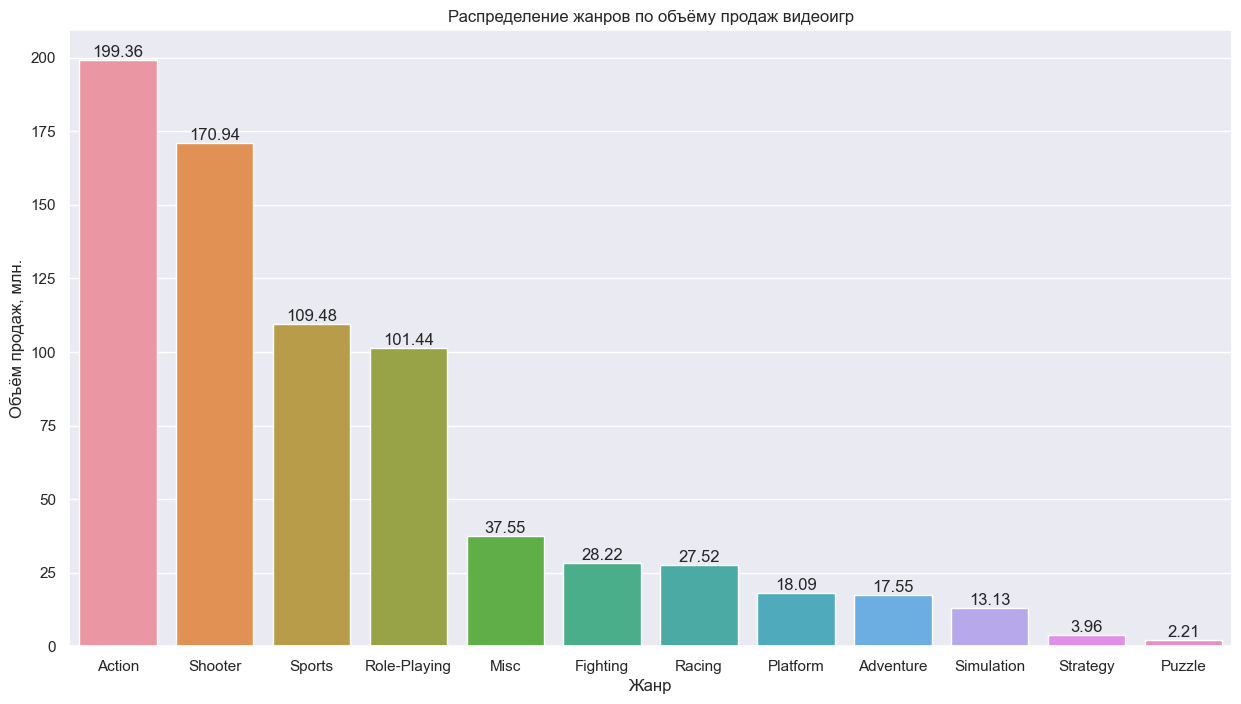

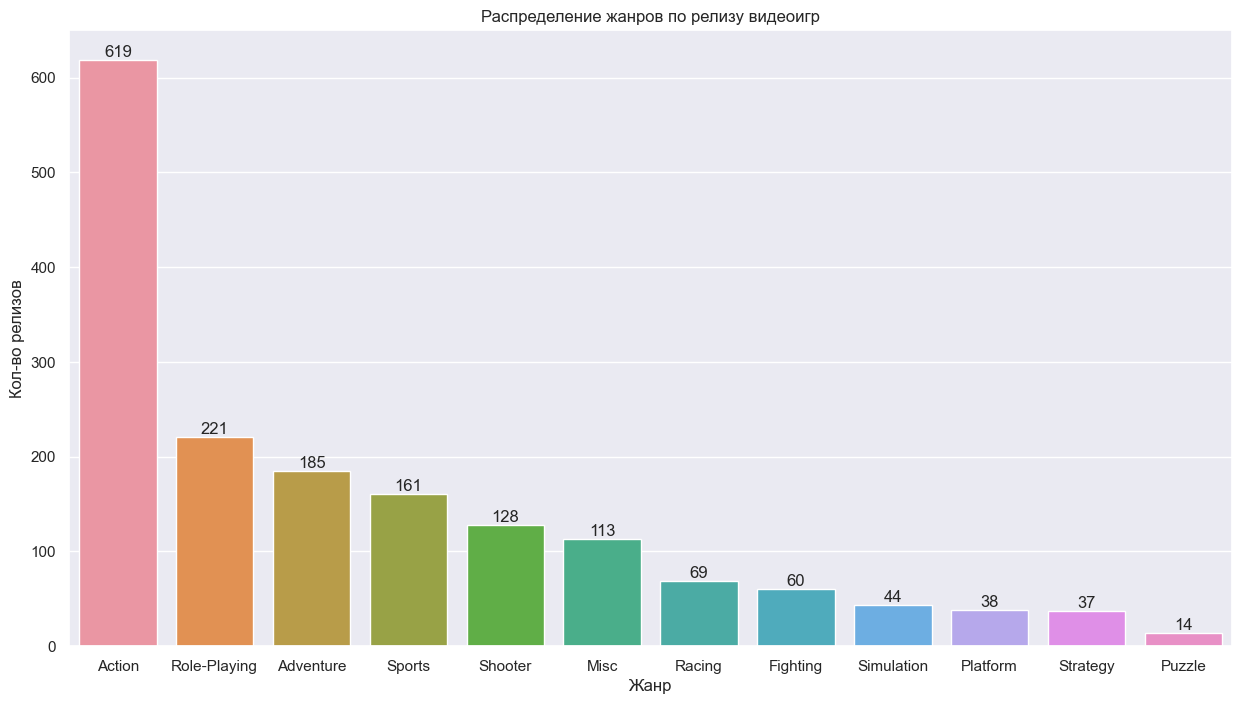

In [76]:
plt.figure(figsize=(15,8))
ax = sns.barplot(data=top_genres, x='genre', y='total_sales')
ax.bar_label(ax.containers[0])
plt.title('Распределение жанров по объёму продаж видеоигр')
plt.ylabel('Объём продаж, млн.')
plt.xlabel('Жанр')
plt.show()

plt.figure(figsize=(15,8))
ax = sns.barplot(data=top_genres.sort_values(by='releases', ascending=False), x='genre', y='releases')
ax.bar_label(ax.containers[0])
plt.title('Распределение жанров по релизу видеоигр')
plt.ylabel('Кол-во релизов')
plt.xlabel('Жанр')
plt.show()

Построим диаграмму размаха для объёма продаж по жанрам

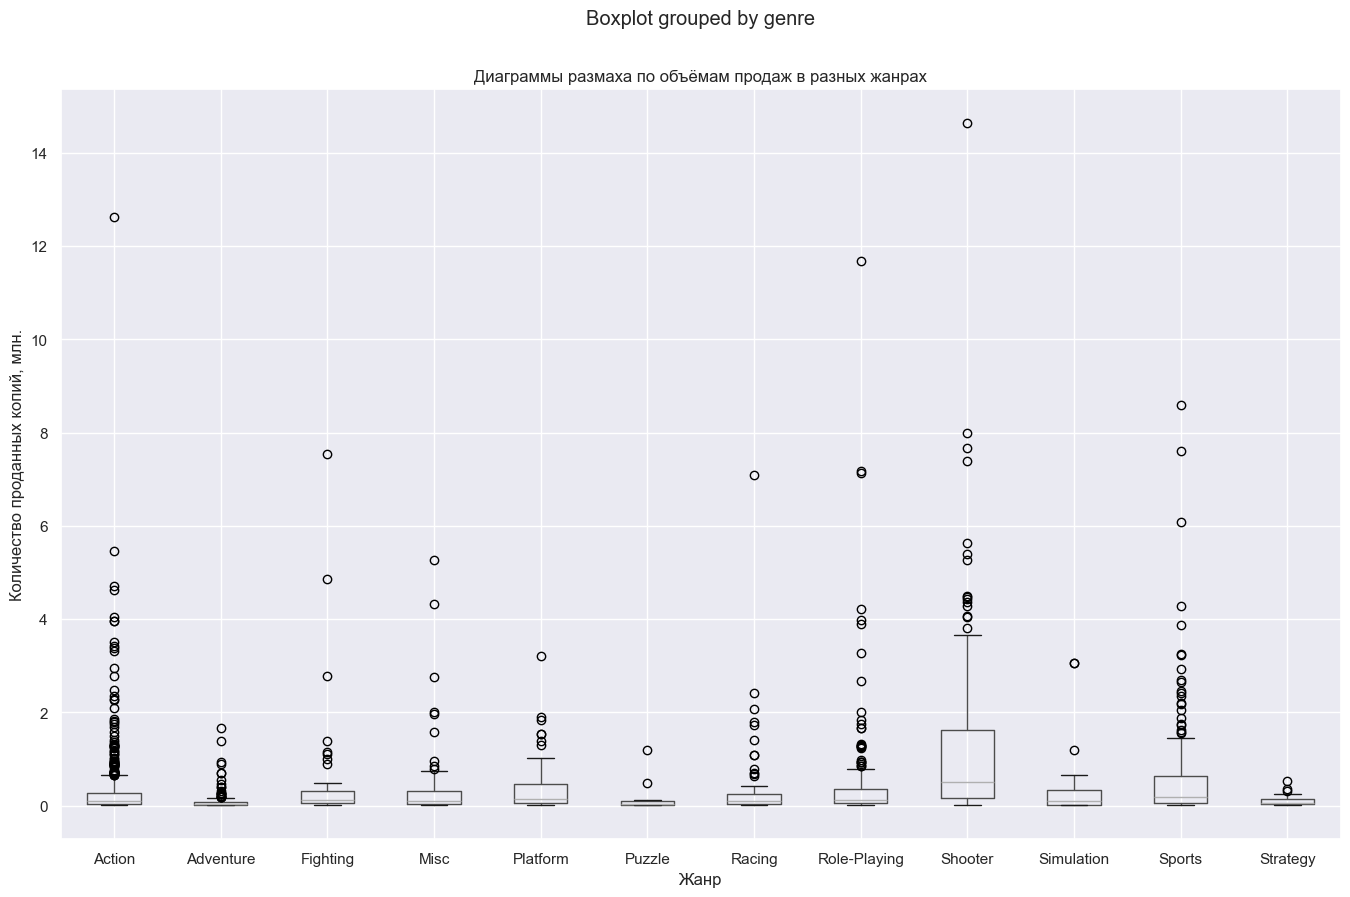

In [77]:
(relevant[['total_sales', 'genre']].boxplot(column='total_sales', by='genre', figsize=(16,10))
)
plt.xlabel('Жанр')
plt.ylabel('Количество проданных копий, млн.')
plt.title('Диаграммы размаха по объёмам продаж в разных жанрах')
plt.show()

Отобразим таблицу с описательной статистикой по объёмам продаж

In [78]:
display(relevant.pivot_table(index='genre', values='total_sales', aggfunc=['mean', 'median', 'std', 'count', 'sum'])\
        .reset_index().sort_values(('median', 'total_sales'), ascending=False))

,genre,mean,median,std,count,sum
,,total_sales,total_sales,total_sales,total_sales,total_sales
8,Shooter,1.34,0.52,2.05,128,170.94
10,Sports,0.68,0.18,1.24,161,109.48
4,Platform,0.48,0.14,0.72,38,18.09
2,Fighting,0.47,0.12,1.19,60,28.22
7,Role-Playing,0.46,0.11,1.18,221,101.44
9,Simulation,0.30,0.10,0.65,44,13.13
0,Action,0.32,0.09,0.80,619,199.36
3,Misc,0.33,0.09,0.74,113,37.55
6,Racing,0.40,0.09,0.96,69,27.52


**Вывод:**
1) Среднее значение объёмов продаж - примерно 60. Медиана равна примерно 28. В межквартильный размах попадают значения от 16.5 до 103.5. В него не попадают такие жанры, как Simulation, Strategy и Puzzle.\
2) Жанры Adventure, Racing, Platform по объёмам продаж меньше медианы в 28 млн. проданных копий.\
3) В 10% самых популярных жанров попадают только Action и Shooter, немного отстаёт от них Role-Playing. Наиболее популярным жанром является Action, наименее - Puzzle. При этом у Action достаточно низкий межквартильный размах по сранению с шутерами или платформенными играми.\
4) Кол-во релизов в общей картине дополняют объёмы продаж.\
5) Рекорд по самым хитовым играм принадлежит жанру Shooter - продано примерно 15 млн. копий. Наименее популярные хиты - стратегии, симуляции и паззлы.\
6) Не преувеличением будет сказать, что лидерами среди жанров являются  Action, Shooter, Role-Playing. При этом Action занимает лидирующую позицию толькуо потому, что у него огромное количество игр в релизе. К примеру, у Shooter кол-во игр меньше почти в 5!!! раз(на 383%), а объём продаж меньше только на 17%. **Так, если бы шутеров было бы только же, сколько и экшенов в релизе, объём их продаж составлял бы 826.7 млн. копий.** Похожая ситуация и с Role-Playing.

**ОБЩИЙ ВЫВОД К ИССЛЕДОВАТЕЛЬСКОМУ АНАЛИЗУ:**

1) Первые игры появились в 1980-х годах. Поначалу их выпускалось немного (не больше 100), однако по мере развития технологий, появления всевозможных девайсов и гаджетов росло и кол-во выпускаемых видеоигр. Заметный рост начался, начиная с начала 1990-х годов. Пик индустрии приходится на 2008-2009 гг., в которых выпущено более 1400 видеоигр. Сразу после 2008-2009 гг. начался резкий спад производства видеоигр, который длился примерно до 2013 гг. Вероятно, это обуловлено мировым экономическим кризисом, произошедшем в 2008 году. На конец наблюдения, а именно 2016 год выпущено около 500 видеоигр, при этом данные за 2016 год не полные.

2) У каждой платформы, кроме ПК, есть свой ограниченный "период жизни". Пик популярности почти каждой платформы приходится примерно на середину соответствующего периода жизни. Его среднее значение равно 7 годам, медиана также равна 7 годам, а мода равна 12 (значение 12 встречается 4 раза). Наиболее популярные платформы, в основном, имеют продолжительность жизни около 10 лет.

3) Мы определили, что период до 1994 года статистически нас не интересует. Помимо этого, выявлено, что средняя продолжительность жизни платформы составляет 7 лет, а у популярных платформ значение часто достигает 10 лет.Однако, стоит учесть, что среди представленных платформ большая часть оставила позади свои лучшие годы, а потому осталось немного подающих надежд платформ. Среди них представлены такие, как PS4, XOne, WiiU, PSV, PS4, 3DS, существующие примерно с 2011 года, а также бессмертный ПК. Учитывая высокую динамичность рынка видеоигр, сократим период исследования до 3-х лет. **Исходя из вышепредставленных выводов, нас интересует период с 2014 по 2016 гг.**

4) Исходя из анализа, перспективными платформами являются: 3DS, PC, PS4, XOne.Такие платформы, как X360 и PS3 находятся на закате своего жизненного периода, и, хотя для них еще продают приличное кол-во игр по состоянию на 2016 год, в 2017 году ситуация может сильно измениться, поскольку выпущены их более популярные преемники - XOne и PS4 соответственно.

5) Построены диаграммы размаха по глобальным продажам игр в разбивке по платформам. Известно, что:
- Самая хитовая игра (15 млн. продаж) представлена у PS4. У нее же, судя по графику и больше всего хитов вообще (учитывая кол-во выбросов), среди популярных платформ меньше всего хитов у PSV И WiiU.

6) Наблюдаем небольшую линейную корреляцию между оценками критиков и объёмами продаж. Никаким образом на объём продаж не влияет оценка игроков, что видно и по графику, поскольку все значения приближены к оси абсцисс. Так влияют на продажи внутри популярных платформ отзывы пользователей и критиков:
- наблюдается небольшая прямая корреляция между оценками критиков и объёмами продаж у платформ XOne, 3DS, WiiU, PC. Для платформы WiiU характерно наличие небольшой связи оценок игроков на результат, чуть большей, чем влияние оценки критиков;
- Для платформы PSV характерно, что ни один из факторов не влияет на результат.
- Среди платформ 3DS, WiiU и PSV заметна достаточно сильная связь между оценка критиков и оценками игроков.

**Таким образом,** заметна тенденция наличия чуть большего влияние на объёмы продаж у такого параметра, как оценка критиков. Исключением здесь является только платформа WiiU.

7) Общая ситуация по прибыльности жанров видеоигр такова:
- Рекорд по самым хитовым играм принадлежит жанру Shooter - продано примерно 15 млн. копий. Наименее популярные хиты - стратегии, симуляции и паззлы.
- Не преувеличением будет сказать, что лидерами среди жанров являются  Action, Shooter, Role-Playing. При этом Action занимает лидирующую позицию толькуо потому, что у него огромное количество игр в релизе. К примеру, у Shooter кол-во игр меньше почти в 5!!! раз(на 383%), а объём продаж меньше только на 17%. **Так, если бы шутеров было бы только же, сколько и экшенов в релизе, объём их продаж составлял бы 826.7 млн. копий.** Похожая ситуация и с Role-Playing.

## Портрет пользователя каждого региона

### Самые популярные платформы (топ-5)

Отобразим первые 10 строк датафрейма

In [79]:
relevant.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,platform_type
0,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,ND,14.63,Консоль
1,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.00,8.30,M,12.62,Консоль
2,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,ND,11.68,Мобильная
3,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.00,4.30,E,8.58,Консоль
4,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,ND,7.98,Консоль
5,Call of Duty: Advanced Warfare,PS4,2014,Shooter,2.81,3.48,0.14,1.23,83.00,5.70,M,7.66,Консоль
6,FIFA 17,PS4,2016,Sports,0.66,5.75,0.08,1.11,85.00,5.00,E,7.60,Консоль
7,Super Smash Bros. for Wii U and 3DS,3DS,2014,Fighting,3.27,1.37,2.43,0.48,NaN,NaN,ND,7.55,Мобильная
8,Call of Duty: Black Ops 3,XOne,2015,Shooter,4.59,2.11,0.01,0.68,NaN,NaN,ND,7.39,Консоль
9,Fallout 4,PS4,2015,Role-Playing,2.53,3.27,0.24,1.13,87.00,6.50,M,7.17,Консоль


Посмотрим на описательную статистику объёмов продаж в разных регионах

In [80]:
relevant[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].describe(percentiles=(0.01,0.05,0.25,0.5,0.75,0.95,0.99))

,na_sales,eu_sales,jp_sales,other_sales
count,1689.00,1689.00,1689.00,1689.00
mean,0.17,0.16,0.06,0.05
std,0.45,0.47,0.21,0.14
min,0.00,0.00,0.00,0.00
1%,0.00,0.00,0.00,0.00
5%,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00
50%,0.02,0.02,0.01,0.01
75%,0.12,0.12,0.04,0.04
95%,0.79,0.72,0.19,0.24


#### Для региона Северная Америка (NA)

Отобразим дф с объёмом и долей продаж в регионе.

In [81]:
top_na_platform = relevant.pivot_table(index='platform', values='na_sales', aggfunc='sum')\
        .sort_values(by='na_sales', ascending=False).head(5).reset_index()
top_na_platform['ratio'] = top_na_platform['na_sales']/ top_na_platform['na_sales'].sum()
display(top_na_platform)

,platform,na_sales,ratio
0,PS4,98.61,0.39
1,XOne,81.27,0.32
2,X360,28.30,0.11
3,3DS,22.64,0.09
4,PS3,22.05,0.09


Отобразим доли на графике

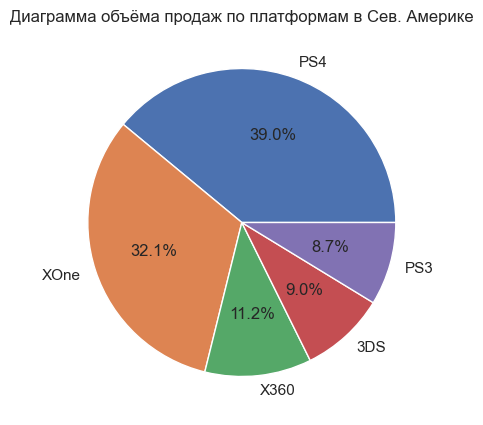

In [82]:
fig, ax = plt.subplots()
labels = top_na_platform['platform']
ax.pie(top_na_platform['ratio'], labels = labels, autopct='%1.1f%%')
plt.title('Диаграмма объёма продаж по платформам в Сев. Америке')
plt.show()

Наиболее популярная платформа для Сев. Америки - PS4 (39%), следом за ней XOne(32.1%), наименее популярная среди топ-5 - PS3(8.7%). Невероятно, но факт, что в США совсем не жалуют ПК.

#### Для региона Европа(EU)

Отобразим дф с объёмом и долей продаж в регионе.

In [83]:
top_eu_platform = relevant.pivot_table(index='platform', values='eu_sales', aggfunc='sum')\
        .sort_values(by='eu_sales', ascending=False).head(5).reset_index()
top_eu_platform['ratio'] = top_eu_platform['eu_sales']/ top_eu_platform['eu_sales'].sum()
display(top_eu_platform)

,platform,eu_sales,ratio
0,PS4,130.04,0.55
1,XOne,46.25,0.20
2,PS3,25.54,0.11
3,PC,17.97,0.08
4,3DS,16.12,0.07


Отобразим доли на графике

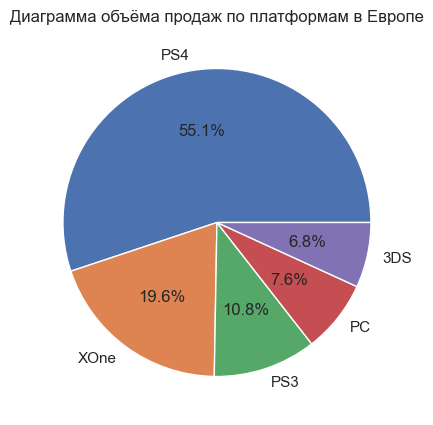

In [84]:
fig, ax = plt.subplots()
labels = top_eu_platform['platform']
ax.pie(top_eu_platform['ratio'], labels = labels, autopct='%1.1f%%')
plt.title('Диаграмма объёма продаж по платформам в Европе')
plt.show()

В Европе наиболее популярна PS4, её выбирают больше половины игроков (55.1%). Остальные платформы сильно отстают. Наименее популярная платформа среди топ-5 - 3DS(6.8%). 

#### Для региона Япония(JP)

Отобразим дф с объёмом и долей продаж в регионе.

In [85]:
top_jp_platform = relevant.pivot_table(index='platform', values='jp_sales', aggfunc='sum')\
        .sort_values(by='jp_sales', ascending=False).head(5).reset_index()
top_jp_platform['ratio'] = top_jp_platform['jp_sales']/ top_jp_platform['jp_sales'].sum()
display(top_jp_platform)

,platform,jp_sales,ratio
0,3DS,44.24,0.48
1,PS4,15.02,0.16
2,PSV,14.54,0.16
3,PS3,11.22,0.12
4,WiiU,7.31,0.08


Отобразим доли на графике

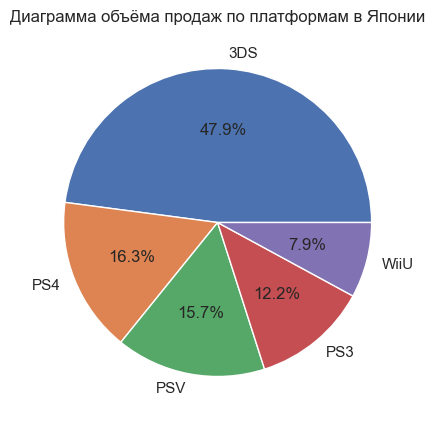

In [86]:
fig, ax = plt.subplots()
labels = top_jp_platform['platform']
ax.pie(top_jp_platform['ratio'], labels = labels, autopct='%1.1f%%')
plt.title('Диаграмма объёма продаж по платформам в Японии')
plt.show()

В Японии почти половина пользователей выбирают платформу 3DS(47.9% игроков). Замыкает топ-5 платформ в Японии - WiiU(7.9%).

#### **Общая картина по популярности платформ**

Отобразим дф с объёмом и долей продаж во всех регионах

In [87]:
top_total_platform = relevant.pivot_table(index='platform', values='total_sales', aggfunc='sum')\
        .sort_values(by='total_sales', ascending=False).head(5).reset_index()
top_total_platform['ratio'] = top_total_platform['total_sales']/ top_total_platform['total_sales'].sum()
display(top_total_platform)

,platform,total_sales,ratio
0,PS4,288.15,0.46
1,XOne,140.36,0.22
2,3DS,86.68,0.14
3,PS3,68.18,0.11
4,X360,48.22,0.08


Отобразим долю на графике

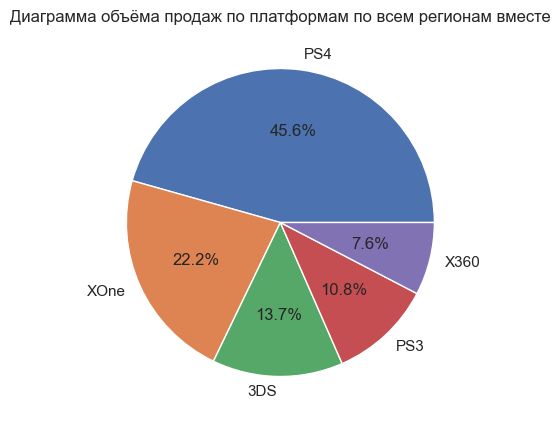

In [88]:
fig, ax = plt.subplots()
labels = top_total_platform['platform']
ax.pie(top_total_platform['ratio'], labels = labels, autopct='%1.1f%%')
plt.title('Диаграмма объёма продаж по платформам по всем регионам вместе')
plt.show()

Для общей картины по всем регионам характерна следующая ситуация: наиболее популярна PS4(около 46%), наименее - X360(7.6%). В топ-5 не представлен долгожитель среди платформ - ПК. Вероятно, это объясняется простотой "пиратства" на нём.

In [89]:
# создадим словарь платформ для использования в визуализации на графике
top5platforms_dict = {}
for region in ['na_sales', 'eu_sales', 'jp_sales']:
    top5platforms_dict[region] = relevant.groupby('platform')[region].sum().sort_values(ascending=False).head(5)

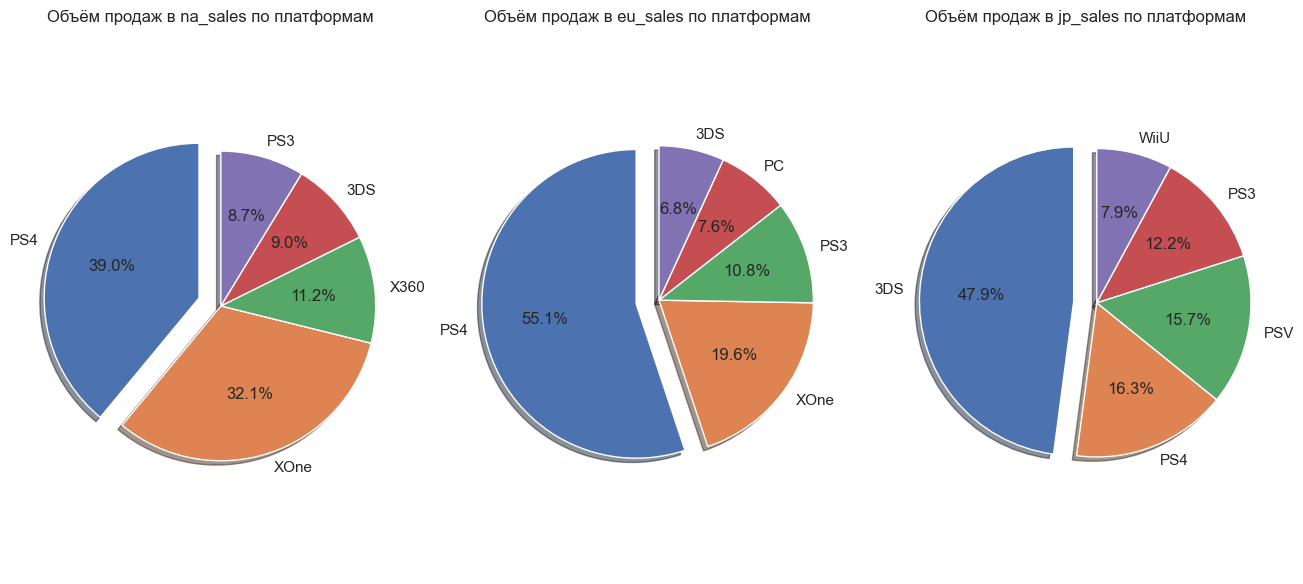

In [90]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))
fig.autofmt_xdate();

#Задаём переменные 
i = 0
x = [ax1, ax2, ax3]
region = ['na_sales', 'eu_sales', 'jp_sales']
explode = (0.15, 0, 0, 0, 0)

#Цикл для вывода диаграмм распределения жанров 
for i in [0,1,2]:
    labels = top5platforms_dict[region[i]].index
    sizes = top5platforms_dict[region[i]].values
    ax = x[i]
    ax.set_title(f'Объём продаж в {region[i]} по платформам')
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True,\
           explode=explode,startangle=90, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }) 
    ax.axis('equal')  

plt.show()

### Самые популярные жанры (топ-5)

Создадим таблицы популярности жанров по регионам

In [91]:
def sales_by_genre(region):
    display(relevant.pivot_table(index='genre', values=region, aggfunc='sum')\
                        .sort_values(by=region, ascending=False).head().reset_index())
    
sales_by_genre('na_sales')

sales_by_genre('eu_sales')

sales_by_genre('jp_sales')

sales_by_genre('total_sales')

,genre,na_sales
0,Shooter,79.02
1,Action,72.53
2,Sports,46.13
3,Role-Playing,33.47
4,Misc,15.05


,genre,eu_sales
0,Action,74.68
1,Shooter,65.52
2,Sports,45.73
3,Role-Playing,28.17
4,Racing,14.13


,genre,jp_sales
0,Role-Playing,31.16
1,Action,29.58
2,Fighting,6.37
3,Misc,5.61
4,Shooter,4.87


,genre,total_sales
0,Action,199.36
1,Shooter,170.94
2,Sports,109.48
3,Role-Playing,101.44
4,Misc,37.55


In [92]:
top5genre_dict = {}
for region in ['na_sales', 'eu_sales', 'jp_sales']:
    top5genre_dict[region] = relevant.groupby('genre')[region].sum().sort_values(ascending=False).head(5)
    

Отобразим доли объёмов продаж по жанрам в различных регионах на графиках

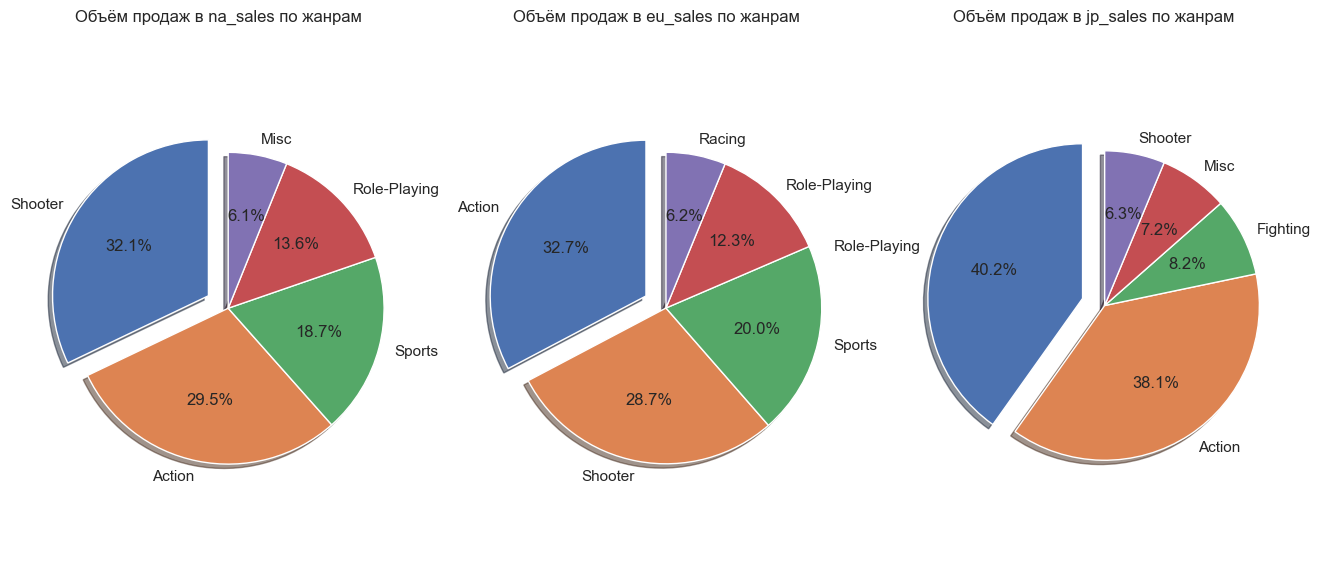

In [93]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))
fig.autofmt_xdate();

#Задаём переменные 
i = 0
x = [ax1, ax2, ax3]
region = ['na_sales', 'eu_sales', 'jp_sales']
explode = (0.15, 0, 0, 0, 0)

#Цикл для вывода диаграмм распределения жанров 
for i in [0,1,2]:
    labels = top5genre_dict[region[i]].index
    sizes = top5genre_dict[region[i]].values
    ax = x[i]
    ax.set_title(f'Объём продаж в {region[i]} по жанрам')
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True,\
           explode=explode,startangle=90, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }) 
    ax.axis('equal')  

plt.show()

США и Европа следуют за общемировой тенденцией: самые популярные игры в этих регионах Action и Shooter. При этом в США лидируют шутеры. На третьем месте в США и Европе, так же, как и в общемировой картине, расположился жанр Sports.\
Особняком стоит Япония, поскольку самым популярным жанром там является Role-Playing. Помимо этого, в топ-5 жанрах в Японии представлен Misc, а вот шутеры (6.3%) представлены на последнем месте среди топ-5 жанров.\
Такие различия, вероятно, обусловлены, отличиями в общеисторических процессах и культурах европейцев (бОльшая часть жителей США - европейцы) и японцев. Известно, что у Японии весьма богатая и мистическая мифология, поэтому островитяне предпочитают Role-Playing игры. Кстати, шутеры в Японии вообще не любят.

### Влияет ли рейтинг ESRB на продажи в отдельном регионе?

Выглядит рейтинг следующим образом:

AO (Adults only 18+) — только для взрослых\
E - everyone - для всех\
M (Mature 17+) — от 17 лет\
T (Teen) — для подростков 13-19 лет\
E10+ (Everyone 10+) — для всех старше 10 лет\
EC (Early Childhood) — для детей младшего возраста\
ND(Not defined) — рейтинг не определён\
RP - категория ещё не присвоена

Основная информация датафрейма

In [94]:
relevant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1689 entries, 0 to 1688
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             1689 non-null   object 
 1   platform         1689 non-null   object 
 2   year_of_release  1689 non-null   int32  
 3   genre            1689 non-null   object 
 4   na_sales         1689 non-null   float64
 5   eu_sales         1689 non-null   float64
 6   jp_sales         1689 non-null   float64
 7   other_sales      1689 non-null   float64
 8   critic_score     718 non-null    float64
 9   user_score       888 non-null    float64
 10  rating           1689 non-null   object 
 11  total_sales      1689 non-null   float64
 12  platform_type    1689 non-null   object 
dtypes: float64(7), int32(1), object(5)
memory usage: 165.1+ KB


Отобразим распределение по возрастным рейтингам

In [95]:
relevant['rating'].value_counts()

rating
ND      749
T       271
M       265
E       219
E10+    185
Name: count, dtype: int64

Создадим сводную таблицу для наглядности

In [96]:
display(relevant.pivot_table(index='rating', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum'))

,eu_sales,jp_sales,na_sales
rating,,,
E,58.06,8.94,50.74
E10+,26.16,4.46,33.23
M,93.44,8.01,96.42
ND,58.95,56.90,64.72
T,34.07,14.78,38.95


Теперь создадим каждую таблицу по региону

In [97]:
for i in ['na_sales', 'eu_sales', 'jp_sales']:
    display(relevant.pivot_table(index='rating', values=i, aggfunc='sum')\
    .sort_values(by=i, ascending=False))

,na_sales
rating,
M,96.42
ND,64.72
E,50.74
T,38.95
E10+,33.23


,eu_sales
rating,
M,93.44
ND,58.95
E,58.06
T,34.07
E10+,26.16


,jp_sales
rating,
ND,56.90
T,14.78
E,8.94
M,8.01
E10+,4.46


Построим график объёмов продаж видеоигр в зависимости от рейтинга по регионам

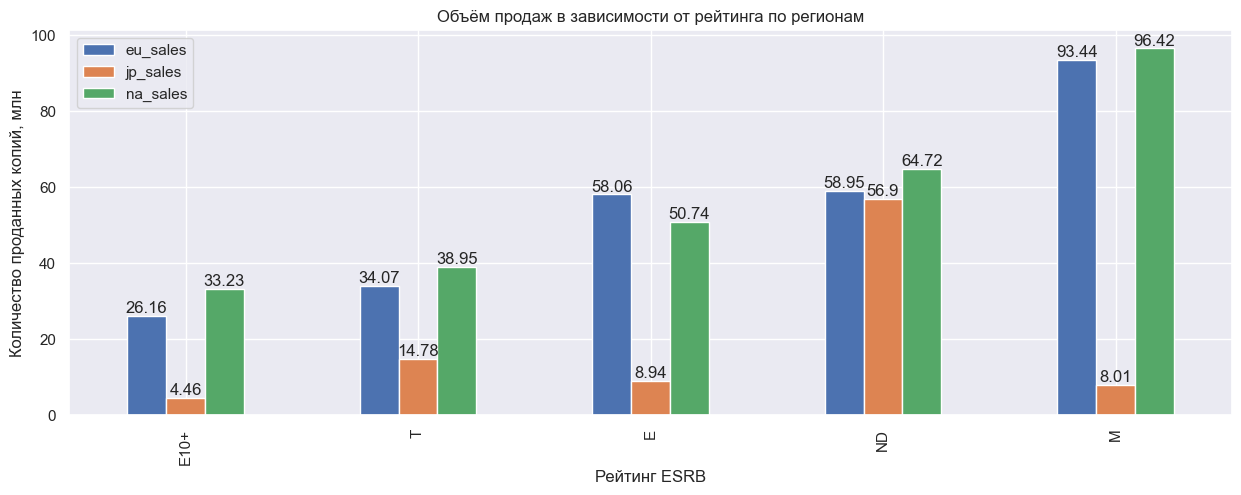

In [98]:
ax = relevant.pivot_table(index='rating', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')\
    .sort_values(by='na_sales')\
    .plot(kind='bar', figsize=(15, 5))

for container in ax.containers:
    ax.bar_label (container) 

plt.xlabel('Рейтинг ESRB')
plt.ylabel('Количество проданных копий, млн')
plt.title('Объём продаж в зависимости от рейтинга по регионам')
plt.show()

Таким образом,\
В Европе и США превыше остальных рейтингов любят M(17+), на втором месте в этих регионах игры с рейтингом ND (категория не определена). Меньше прочих в США И Европе покупают игры с рейтингом E10(для всех старше 10 лет).\
В Японии больше пользователи покупают, в основном, игры с категорий ND(не определено в условиях нашего даатфрейма). Это может быть связано с тем, что многие японские игры не доходят до оценки североамериканскими критиками ESRB, к тому же в Японии существует своя система критики видеоигр CERO. На втором месте в Японии игры с рейтингом T(13+). Игр категорий М(17+) и E(для всех возрастных категорий) достаточно мало. Вероятно, японцы более миролюбивые и меньше любят насилие.


**ОБЩИЙ ВЫВОД:**

Портрет пользователя из США:\
играет, в основном, на консолях(PS4 или XOne), предпочитает жанры Shooter и Action в играх с рейтингом M.

Портрет пользователя из Европы:
играет на PS4, предпочитает жанры Action и Shooter, в играх с рейтингом M.

Портрет пользователя из Японии:
играет на Nintendo 3DS, предпочитает Role-Playing и Action в играх с рейтингом T. Из сторонних источников известно, что больше половины всех видеоигр в Японии составляют игры с возрастной категорий "Для всех возрастов" - аналог американской оценки E.

## Проверка гипотез

Зададим уровень статистической значимости в 5%.

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Используем двухвыборочный t-тест для проверки двусторонней альтернативной гипотезы, поскольку используются две независимые выборки из одной ген. совокупности.\
H0: средние пользовательские рейтинги платформ Xbox One и PC равны.\
H1: средние пользовательские рейтинги платформ Xbox One и PC не равны.

In [99]:
# создадим дополнительные датафреймы для анализа
xone = relevant.dropna(subset=['user_score']).query('platform == "XOne"')
pc = relevant.dropna(subset=['user_score']).query('platform == "PC"')

Отобразим описательную статистику

In [100]:
display(relevant.dropna(subset=['user_score']).query('platform in ["XOne", "PC"]')
        .pivot_table(index='platform', values='user_score', aggfunc=['count', 'mean', 'median', 'var']))

,count,mean,median,var
,user_score,user_score,user_score,user_score
platform,,,,
PC,122,6.30,6.80,2.90
XOne,165,6.59,6.80,1.89


In [101]:
# размеры выборок сильно отличаются, поэтому сделаем предположение о неравенстве дисперсий
results = st.ttest_ind(xone['user_score'], pc['user_score'], alternative='two-sided', equal_var=False)

print(f'p-value: {results.pvalue}')
if results.pvalue < 0.05:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

p-value: 0.11601398086668832
Не удалось отвергнуть нулевую гипотезу


**С большой долей вероятности средние пользовательские рейтинги платформ XOne и PC не имеют статистически значимых отличий**

### Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Прибегнем к использованию двухвыборочного теста для проверки двусторонней альтернативной гипотезы, поскольку используются две независимые выборки из одной ген. совокупности.\
H0: средние пользовательские рейтинги жанров Action и Sports равны.\
H1: средние пользовательские рейтинги жанров Action и Sports не равны.

In [102]:
action = relevant.dropna(subset=['user_score']).query('genre == "Action"')
sports = relevant.dropna(subset=['user_score']).query('genre == "Sports"')

In [103]:
display(relevant.dropna(subset=['user_score']).query('genre in ["Action", "Sports"]')
        .pivot_table(index='genre', values='user_score', aggfunc=['count', 'mean', 'median', 'var']))

,count,mean,median,var
,user_score,user_score,user_score,user_score
genre,,,,
Action,297,6.76,7.10,1.90
Sports,127,5.23,5.50,3.45


In [104]:
# размеры выборок сильно отличаются, поэтому сделаем предположение о неравенстве дисперсий
results = st.ttest_ind(action['user_score'], sports['user_score'], alternative='two-sided', equal_var=False)

print(f'p-value: {results.pvalue}')
if results.pvalue < 0.05:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

p-value: 1.1825550382644557e-14
Отвергаем нулевую гипотезу


**Есть основания предполагать, что средние пользовательские рейтинги жанров Action и Sports отличаются**

## ОБЩИЙ ВЫВОД

1) Предобработка данных:
- названия столбцов приведены к нижнему регистру;
- данные преобразованы в необходимые типы;
- объяснены и ликвидированы пропуски там, где возможно;
- добавлен столбец с суммарными продажами по всем регионам.

2) Исследовательский анализ:

- Первые игры появились в 1980-х годах. Поначалу их выпускалось немного (не больше 100), однако по мере развития технологий, появления всевозможных девайсов и гаджетов росло и кол-во выпускаемых видеоигр. Заметный рост начался, начиная с начала 1990-х годов. Пик индустрии приходится на 2008-2009 гг., в которых выпущено более 1400 видеоигр. Сразу после 2008-2009 гг. начался резкий спад производства видеоигр, который длился примерно до 2013 г. Вероятно, это обуловлено мировым экономическим кризисом, произошедшем в 2008 году. На конец наблюдения, а именно 2016 год выпущено около 500 видеоигр, при этом данные за 2016 год могут быть не полными;
- У каждой платформы, кроме ПК, есть свой ограниченный "период жизни". Пик популярности почти каждой платформы приходится примерно на середину соответствующего периода жизни. Его среднее значение и медиана равны 7 годам. У популярных платформ "период жизни" выше и составляет около 10 лет;
- Актуальный период исследования: с 2014 по 2016 гг.;
- Наиболее перспективные платформы: 3DS, PC, PS4, XOne; 
- Самая хитовая игры (15 млн. продаж) представлена у PS4. У неё же, судя по графику и больше всего хитов вообще, меньше всего хитов у PSV И WiiU.

3) Портрет пользователя по регионам:

- Портрет пользователя из США: играет, в основном, на консолях(PS4 или XOne), предпочитает жанры Shooter и Action в играх с рейтингом M.

- Портрет пользователя из Европы: играет на PS4, предпочитает жанры Action и Shooter, в играх с рейтингом M.

- Портрет пользователя из Японии: играет на Nintendo 3DS, предпочитает Role-Playing и Action в играх с рейтингом T. Из сторонних источников известно, что больше половины всех видеоигр в Японии составляют игры с возрастной категорий "Для всех возрастов" - аналог американской оценки E.

4) Проверка гипотез:

- С большой долей вероятности средние пользовательские рейтинги платформ XOne и PC не имеют статистически значимых отличий;
- Есть основания предполагать, что средние пользовательские рейтинги жанров Action и Sports отличаются.

**Исходя из анализа, для того, чтобы преуспеть в продаже видеоигр, необходимо обратить внимания на перспективные платформы PS4, XOne (на американском и европейском рынках), Nintendo 3DS (на японском рынке), а также вечный PC. \
На американских и европейских рынках стоит сделать акцент на продажу игр жанра Action и Shooter с рейтингом M и E, на японском рынке - Role-Playing и Action с рейтингом E и T.**